In [52]:
# Import libraries

import os
import re
import math
import spacy
import random
import unidecode
import unicodedata
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from collections import Counter
from decimal import Decimal
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.pipeline import make_pipeline
from tensorflow.keras import layers, optimizers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

import tokenizer
import transformers
from transformers import AutoTokenizer

%matplotlib inline

nlp = spacy.load('en_core_web_sm')

In [2]:
# Load dataset

data_csv = pd.read_csv('./final_data.csv')
df = pd.DataFrame(data_csv)

In [3]:
# Function for preprocessing lyrics

def preprocess_text(text, tokenise=False, to_lower=False, remove_punct=False, remove_space=False, exp_contractions=False, remove_accents=False, remove_html=False, lemmatise=False):
    """Arguments:
        text (str): The text to be preprocessed
        tokenise (bool): Whether to return a list of tokens or a string
        to_lower (bool): Whether to convert text to lowercase
        remove_punct (bool/str): Whether to remove punctuation or a specific character
        remove_space (bool): Whether to remove whitespace characters
        exp_contractions (bool): Whether to expand contractions
        remove_accents (bool): Whether to remove accents
        remove_html (bool): Whether to remove HTML tags
        lemmatise (bool): Whether to lemmatise tokens
    """


    def fix_punctuation(text):
        cleaned_text = re.sub(r'\[.*?\]', '', text)
        corrected_text = re.sub(r'([.!?])([A-Z])', r'\1 \2', cleaned_text)
        return corrected_text
    if type(text) == str:
        text = fix_punctuation(text)
    
    def _join_punctuation(data):
        characters = ".,!?'’:;"
        characters = set(characters)
        for token in data:
            if any(char in token for char in characters):
                index = data.index(token)
                data[index-1] = data[index-1] + data[index]
                data.remove(token)
        return data
    
    if tokenise:
        doc = nlp(text)
#        for sent in doc.sents:
#            sent = [token for token in sent if not token.is_stop]
        sent = [token.text for token in doc]
        result = sent
    if tokenise == False:
        result = text

    if exp_contractions:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.text for token in doc]
            sent = _join_punctuation(sent)
            sent = ' '.join(sent)
            doc2 = nlp(sent)
            sent_list = []
            for sent2 in doc2.sents:
                sent2 = contractions.fix(sent2.text)
                sent_list.append(sent2)
            if len(sent_list) == 1:
                result = sent_list[0]
            elif len(sent_list) > 1:
                result = ' '.join(sent_list)
        elif type(result) == list:
            result = _join_punctuation(result)
            result = ' '.join(result)
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = contractions.fix(sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                doc2 = nlp(sent_list[0])
            elif len(sent_list) > 1:
                doc2 = nlp(' '.join(sent_list))
            sent2 = [token.text for token in doc2]
            result = sent2
        
    if lemmatise:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.lemma_ for token in doc]
            sent = _join_punctuation(sent)
            sent = ' '.join(sent)
            result = sent
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.lemma_ for token in doc]
            result = sent
    
    if to_lower:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.lower_ for token in doc]
            sent = _join_punctuation(sent)
            result = ' '.join(sent)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.lower_ for token in doc]
#            sent = _join_punctuation(sent)
            result = sent

    if remove_html:
        if type(result) == str:
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = re.sub('<.*?>', '', sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                result = sent_list[0]
            elif len(sent_list) > 1:
                result = ' '.join(sent_list)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = re.sub('<.*?>', '', sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                doc2 = nlp(sent_list[0])
            elif len(sent_list) > 1:
                doc2 = nlp(' '.join(sent_list))
            sent2 = [token.text for token in doc2]
            result= sent2
    
    if remove_punct:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_punct]
            sent = _join_punctuation(sent)
            sent = ' '.join(sent)
            result = sent
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_punct]
#            sent = _join_punctuation(sent)
            result = sent
            
    if remove_space:
        if type(result) == str:
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_space]
            sent = _join_punctuation(sent)
            result = ' '.join(sent)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent = [token.text for token in doc if not token.is_space]
#           sent = _join_punctuation(sent)
            result = sent
            
    if remove_accents:
        if type(result) == str:
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = unidecode.unidecode(sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                result = sent_list[0]
            elif len(sent_list) > 1:
                result = ' '.join(sent)
        elif type(result) == list:
            result = ' '.join(result)
            doc = nlp(result)
            sent_list = []
            for sent in doc.sents:
                sent = unidecode.unidecode(sent.text)
                sent_list.append(sent)
            if len(sent_list) == 1:
                doc2 = nlp(sent_list[0])
            elif len(sent_list) > 1:
                doc2 = nlp(' '.join(sent_list))
            sent2 = [token.text for token in doc2]
            result = sent2
  
    return result

In [6]:
# Preprocessing lyrics

lyrics = df['lyrics'].to_list()

preprocessed_lyrics_tokens = []
for lyric in lyrics:
    processed = preprocess_text(lyric, tokenise=True, to_lower=True, remove_punct=True, remove_space=True, exp_contractions=True, remove_accents=True, remove_html=True, lemmatise=True)
    preprocessed_lyrics_tokens.append(processed) 

preprocessed_lyrics = []
for lyr in preprocessed_lyrics_tokens:
    preprocessed_lyrics.append(' '.join(lyr))

df['processed_lyrics'] = preprocessed_lyrics

In [7]:
# Create vocabulary

def create_vocab(lyric_tokens, vocab_size):

    processed_lyric = ' '.join(lyric_tokens)
    doc = nlp(processed_lyric)
    tokens = []

    for sent in doc.sents:
        sent = [token for token in sent if not token.is_stop]
        tokens.extend(sent)
        
    word_counter = Counter(tokens)

    vocab = []
    vocab.extend([word.text for word, count in word_counter.most_common(vocab_size)])

    vocab = list(dict.fromkeys(vocab))
    
    vocab = vocab[:vocab_size]
    
    return vocab

nlp.max_length = 2000000
combined_lyrics = [word for sublist in preprocessed_lyrics_tokens for word in sublist]
all_vocab = create_vocab(combined_lyrics, 2000)

In [8]:
# Create model for neural networks

max_seq_len = 600

vectorise_layer = layers.TextVectorization(
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=max_seq_len,
    pad_to_max_tokens=False,
    vocabulary=all_vocab
)
vocab = vectorise_layer.get_vocabulary()

sentences = []
for sent in df['processed_lyrics']:
    tok = []
    sent = sent.split()
    for token in sent:
        tok.append(token)
    sentences.append(tok)
    
sentences = pd.Series(sentences)

embedding_dim = 150
w2v_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=2, sg=1, epochs=3, seed=42, workers=4)
w2v_model.save(os.path.join('/Users/hikmetsinanustun/Desktop/final_project/model', 'circumplex_model.model'))
# Change save path if you wish if running code
circumplex_model = Word2Vec.load(os.path.join('/Users/hikmetsinanustun/Desktop/final_project/model', 'circumplex_model.model'))

**RECURRENT NEURAL NETWORKS (RNN)**

In [9]:
# Build Recurrent Neural Networks (RNN) model

def build_model(vocab_size, embedding_dim, max_seq_len, vectorise_layer, units, activation, optimiser, lr, loss):

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(vocab):
        if word in circumplex_model.wv.key_to_index:
            embedding_matrix[i] = circumplex_model.wv.get_vector(word)[:embedding_dim]
        
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True)
    
    inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)

    vectorised_inputs = vectorise_layer(inputs)

    embedded_inputs = embedding_layer(vectorised_inputs)

    lstm_layer_1 = layers.LSTM(units, return_sequences=True)(embedded_inputs)

    lstm_layer_2 = layers.LSTM(units)(lstm_layer_1)

    dense_layer = layers.Dense(units, activation=activation)(lstm_layer_2)

    output_x = layers.Dense(1, activation=activation, name='x_output')(dense_layer)
    output_y = layers.Dense(1, activation=activation, name='y_output')(dense_layer)

    optimizer = tf.keras.optimizers.get(optimiser)
    optimizer.learning_rate.assign(lr)
    
    model = tf.keras.Model(inputs=inputs, outputs=[output_x, output_y], name="LSTM_Regression")
    model.compile(optimizer=optimiser, loss=loss, metrics=['mse', 'mse'])

    return model

model = build_model(vocab_size=2000, embedding_dim=embedding_dim,
                    max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, 
                    activation='sigmoid', optimiser='adam', 
                    lr=0.001, loss="mse")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
# Train and test the model

X = df['processed_lyrics'].values
y = df['x'].values
z = df['y'].values

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.25, random_state=42)

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results = model.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 2)

train_loss = results.history['loss']
val_loss = results.history['val_loss']

min_val_loss = min(val_loss)
min_loss_index = val_loss.index(min_val_loss)

opt_train_loss = train_loss[min_loss_index]

predictions_xcoord, predictions_ycoord = model.predict(X_test)

mse_xcoord = mean_squared_error(y_test, predictions_xcoord)
mse_ycoord = mean_squared_error(z_test, predictions_ycoord)

Epoch 1/100
5/5 - 5s - 928ms/step - loss: 0.6379 - x_output_mse: 0.4326 - y_output_mse: 0.2053 - val_loss: 0.5417 - val_x_output_mse: 0.3548 - val_y_output_mse: 0.1869
Epoch 2/100
5/5 - 3s - 630ms/step - loss: 0.5807 - x_output_mse: 0.3945 - y_output_mse: 0.1862 - val_loss: 0.4976 - val_x_output_mse: 0.3262 - val_y_output_mse: 0.1714
Epoch 3/100
5/5 - 3s - 610ms/step - loss: 0.5322 - x_output_mse: 0.3618 - y_output_mse: 0.1704 - val_loss: 0.4672 - val_x_output_mse: 0.3051 - val_y_output_mse: 0.1622
Epoch 4/100
5/5 - 3s - 633ms/step - loss: 0.4988 - x_output_mse: 0.3379 - y_output_mse: 0.1609 - val_loss: 0.4509 - val_x_output_mse: 0.2925 - val_y_output_mse: 0.1583
Epoch 5/100
5/5 - 3s - 605ms/step - loss: 0.4795 - x_output_mse: 0.3224 - y_output_mse: 0.1571 - val_loss: 0.4419 - val_x_output_mse: 0.2848 - val_y_output_mse: 0.1571
Epoch 6/100
5/5 - 3s - 640ms/step - loss: 0.4675 - x_output_mse: 0.3124 - y_output_mse: 0.1551 - val_loss: 0.4368 - val_x_output_mse: 0.2800 - val_y_output_mse:

**CONVOLUTIONAL NEURAL NETWORKS (CNN)**

In [11]:
# Convolutional Neural Networks

def cnn_build_model(vocab_size, embedding_dim, max_seq_len, vectorise_layer, units, activation, optimiser, lr, loss):

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(vocab):
        if word in circumplex_model.wv.key_to_index:
            embedding_matrix[i] = circumplex_model.wv.get_vector(word)[:embedding_dim]

    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True,
        trainable=True
    )

    inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)

    vectorised_inputs = vectorise_layer(inputs)

    embedded_inputs = embedding_layer(vectorised_inputs)

    conv1 = layers.Conv1D(filters=units, kernel_size=3, activation=activation, padding='valid')(embedded_inputs)
    conv2 = layers.Conv1D(filters=units, kernel_size=3, activation=activation, padding='valid')(conv1)
    pooling = layers.GlobalMaxPooling1D()(conv2)

    dense_layer = layers.Dense(units, activation=activation)(pooling)

    output_x = layers.Dense(1, activation=activation, name='x_output')(dense_layer)
    output_y = layers.Dense(1, activation=activation, name='y_output')(dense_layer)

    optimizer = tf.keras.optimizers.get(optimiser)
    optimizer.learning_rate = lr

    model = tf.keras.Model(inputs=inputs, outputs=[output_x, output_y], name="CNN_Regression")
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mse'])

    return model

cnn_model = cnn_build_model(vocab_size=2000, embedding_dim=150,
                    max_seq_len=600, vectorise_layer=vectorise_layer, units=32, 
                    activation='sigmoid', optimiser='adam', 
                    lr=0.001, loss="mse")

cnn_model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "CNN_Regression"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 600)       │          0 │ input_layer_1[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 600, 150)  │    300,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 598, 32)   │     14,432 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 596, 32)   │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_output (Dense)    │ (None, 1)         │         33 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_output (Dense)    │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 318,658 (1.22 MB)

 Trainable params: 318,658 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train and test Convolutional Neural Networks (CNN)

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results1 = cnn_model.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 2)

cnn_train_loss1 = cnn_results1.history['loss']
cnn_val_loss1 = cnn_results1.history['val_loss']

min_val_loss1_cnn = min(cnn_val_loss1)
min_val_loss_index1_cnn = cnn_val_loss1.index(min_val_loss1_cnn)

optimal_train_loss1_cnn = cnn_train_loss1[min_val_loss_index1_cnn]

cnn_predictions_xcoord, cnn_predictions_ycoord = cnn_model.predict(X_test)

cnn_mse_xcoord1 = mean_squared_error(y_test, cnn_predictions_xcoord)
cnn_mse_ycoord1 = mean_squared_error(z_test, cnn_predictions_ycoord)

Epoch 1/100


5/5 - 1s - 264ms/step - loss: 0.5940 - x_output_mse: 0.3695 - y_output_mse: 0.2245 - val_loss: 0.5144 - val_x_output_mse: 0.3166 - val_y_output_mse: 0.1978
Epoch 2/100
5/5 - 0s - 79ms/step - loss: 0.5519 - x_output_mse: 0.3551 - y_output_mse: 0.1968 - val_loss: 0.4853 - val_x_output_mse: 0.3068 - val_y_output_mse: 0.1784
Epoch 3/100
5/5 - 0s - 80ms/step - loss: 0.5208 - x_output_mse: 0.3426 - y_output_mse: 0.1782 - val_loss: 0.4658 - val_x_output_mse: 0.2987 - val_y_output_mse: 0.1671
Epoch 4/100
5/5 - 0s - 82ms/step - loss: 0.4986 - x_output_mse: 0.3316 - y_output_mse: 0.1669 - val_loss: 0.4535 - val_x_output_mse: 0.2914 - val_y_output_mse: 0.1622
Epoch 5/100
5/5 - 0s - 79ms/step - loss: 0.4836 - x_output_mse: 0.3219 - y_output_mse: 0.1617 - val_loss: 0.4455 - val_x_output_mse: 0.2861 - val_y_output_mse: 0.1594
Epoch 6/100
5/5 - 0s - 83ms/step - loss: 0.4736 - x_output_mse: 0.3150 - y_output_mse: 0.1586 - val_loss: 0.4403 - val_x_output_mse: 0.2825 - val_y_output_mse: 0.1578
Epoch 7/1

**LR, SVR, KNN & RANDOM FOREST**

In [13]:
# Create vectors for machine learning algorithms other than neural networks

averaged_vectors = []

for lyric in df['processed_lyrics']:
    doc = nlp(lyric)
    vectors = [token.vector for token in doc if token.has_vector]
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros((nlp.vocab.vectors_length,))
    averaged_vectors.append(mean_vector)

df['lyrics_vector'] = averaged_vectors

In [14]:
# Train and test models

X_vectors = np.array(df['lyrics_vector'].tolist())
X_train_vectors, X_test_vectors = train_test_split(X_vectors, test_size=0.25, random_state=42)

lr_model = LinearRegression()
svr_model = SVR(kernel='linear')
knn_model = KNeighborsRegressor(n_neighbors=5)
rf_model = RandomForestRegressor(n_estimators= 600, min_samples_split= 5, min_samples_leaf= 2, max_features= 'log2', max_depth= 10)


models = [lr_model, svr_model, knn_model, rf_model]
xcoord_results = []
ycoord_results = []
model_predictions_x = []
model_predictions_y = []

for model in models:
    model.fit(X_train_vectors, y_train)
    predictions = model.predict(X_test_vectors)
    model_predictions_x.append(predictions)
    model_mse = round(mean_squared_error(y_test, predictions),4)
    xcoord_results.append(model_mse)
    model.fit(X_train_vectors, z_train)
    predictions = model.predict(X_test_vectors)
    model_predictions_y.append(predictions)
    model_mse = round(mean_squared_error(z_test, predictions),4)
    ycoord_results.append(model_mse)

**RESULTS OF ALL MODELS**

In [16]:
# All results

print('Loss and Mean Squared Error (MSE) Results for x-coordinate Predictions')
print('-'*50)
print(f'Minimum loss value for Recurrent Neural Network (RNN): {round(min_val_loss,4)}')
print(f'Minimum loss value for Convolutional Neural Network (CNN): {round(min_val_loss1_cnn,4)}')
print('-'*50)
print(f'Mean squared error (mse) for Recurrent Neural Networks (RNN) - x coordinates: {round(mse_xcoord,4)}')
print(f'Mean squared error (mse) for Convolutional Neural Networks (CNN) - x coordinates: {round(cnn_mse_xcoord1,4)}')
ml_models = ['Linear Regression', 'K-Nearest Neighbor', 'Support Vector Regressor', 'Random Forest Regressor']
for i in range (len(ml_models)):
    print(f'Mean squared error (mse) for {ml_models[i]} - x coordinates: {xcoord_results[i]}')
print('-'*50)
print(f'Mean squared error (mse) for Recurrent Neural Networks (RNN) - y coordinates: {round(mse_ycoord,4)}')
print(f'Mean squared error (mse) for Convolutional Neural Networks (CNN) - y coordinates: {round(cnn_mse_ycoord1,4)}')
for i in range (len(ml_models)):
    print(f'Mean squared error (mse) for {ml_models[i]} - y coordinates: {ycoord_results[i]}')

Loss and Mean Squared Error (MSE) Results for x-coordinate Predictions
--------------------------------------------------
Minimum loss value for Recurrent Neural Network (RNN): 0.4274
Minimum loss value for Convolutional Neural Network (CNN): 0.4137
--------------------------------------------------
Mean squared error (mse) for Recurrent Neural Networks (RNN) - x coordinates: 0.3017
Mean squared error (mse) for Convolutional Neural Networks (CNN) - x coordinates: 0.3008
Mean squared error (mse) for Linear Regression - x coordinates: 0.3139
Mean squared error (mse) for K-Nearest Neighbor - x coordinates: 0.3419
Mean squared error (mse) for Support Vector Regressor - x coordinates: 0.3288
Mean squared error (mse) for Random Forest Regressor - x coordinates: 0.2801
--------------------------------------------------
Mean squared error (mse) for Recurrent Neural Networks (RNN) - y coordinates: 0.1436
Mean squared error (mse) for Convolutional Neural Networks (CNN) - y coordinates: 0.1277
Me

**EXPERIMENTS ON RNN**

In [ ]:
# Create RNN models for different scenarios

def build_model(vocab_size, embedding_dim, max_seq_len, vectorise_layer, units, activation, optimiser, lr, loss):

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(vocab):
        if word in circumplex_model.wv.key_to_index:
            embedding_matrix[i] = circumplex_model.wv.get_vector(word)[:embedding_dim]
        
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True)
    
    inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)

    vectorised_inputs = vectorise_layer(inputs)

    embedded_inputs = embedding_layer(vectorised_inputs)

    lstm_layer_1 = layers.LSTM(units, return_sequences=True)(embedded_inputs)

    lstm_layer_2 = layers.LSTM(units)(lstm_layer_1)

    dense_layer = layers.Dense(units, activation=activation)(lstm_layer_2)

    output_x = layers.Dense(1, activation=activation, name='x_output')(dense_layer)
    output_y = layers.Dense(1, activation=activation, name='y_output')(dense_layer)

    optimizer = tf.keras.optimizers.get(optimiser)
    optimizer.learning_rate.assign(lr)
    
    model = tf.keras.Model(inputs=inputs, outputs=[output_x, output_y], name="LSTM_Regression")
    model.compile(optimizer=optimiser, loss=loss, metrics=['mse', 'mse'])

    return model

model1 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='adam', lr=0.01, loss="mse") 
model2 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='rmsprop', lr=0.01, loss="mse") 
model3 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='sgd', lr=0.01, loss="mse") 
model4 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='adam', lr=0.01, loss="mse") 
model5 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='rmsprop', lr=0.01, loss="mse") 
model6 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='sgd', lr=0.01, loss="mse") 
model7 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='adam', lr=0.01, loss="mse") 
model8 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='rmsprop', lr=0.01, loss="mse") 
model9 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='sgd', lr=0.01, loss="mse") 
model10 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='adagrad', lr=0.01, loss="mse") 
model11 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='adagrad', lr=0.01, loss="mse") 
model12 = build_model(vocab_size=2000, embedding_dim=150, max_seq_len=600, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='adagrad', lr=0.01, loss="mse") 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Define train and test data

X = df['processed_lyrics'].values
y = df['x'].values
z = df['y'].values

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.25, random_state=42)

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

In [ ]:
# Results of scenario 1: Activation: SIGMOID / Optimiser: ADAM

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results1 = model1.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history1 = results1.history['val_loss']
train_loss_history1 = results1.history['loss']
min_val_loss1 =min(val_loss_history1)

predictions_xcoord1, predictions_ycoord1 = model1.predict(X_test)

mse_xcoord1 = mean_squared_error(y_test, predictions_xcoord1)
mse_ycoord1 = mean_squared_error(z_test, predictions_ycoord1)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - loss: 0.4495 - x_output_mse: 0.2926 - y_output_mse: 0.1569 - val_loss: 0.4274 - val_x_output_mse: 0.2703 - val_y_output_mse: 0.1571
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - loss: 0.4510 - x_output_mse: 0.2954 - y_output_mse: 0.1556 - val_loss: 0.4275 - val_x_output_mse: 0.2703 - val_y_output_mse: 0.1572
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - loss: 0.4434 - x_output_mse: 0.2899 - y_output_mse: 0.1535 - val_loss: 0.4275 - val_x_output_mse: 0.2702 - val_y_output_mse: 0.1572
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - loss: 0.4388 - x_output_mse: 0.2907 - y_output_mse: 0.1481 - val_loss: 0.4276 - val_x_output_mse: 0.2702 - val_y_output_mse: 0.1574
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - loss: 0.4363 - x_output_mse: 0.2897 - y_output_mse: 0.1466 - val_loss: 0.4277 - val_x_output_mse: 0.2701 - val_y_output_mse: 0.1575
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.4446 - x_output_mse: 0.291

In [ ]:
# Results of scenario 2: Activation: SIGMOID / Optimiser: RMSPROP

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results2 = model2.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history2 = results2.history['val_loss']
train_loss_history2 = results2.history['loss']
min_val_loss2 =min(val_loss_history2)

predictions_xcoord2, predictions_ycoord2 = model2.predict(X_test)

mse_xcoord2 = mean_squared_error(y_test, predictions_xcoord2)
mse_ycoord2 = mean_squared_error(z_test, predictions_ycoord2)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - loss: 0.8364 - x_output_mse: 0.6486 - y_output_mse: 0.1877 - val_loss: 0.6343 - val_x_output_mse: 0.4680 - val_y_output_mse: 0.1663
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - loss: 0.6910 - x_output_mse: 0.5312 - y_output_mse: 0.1597 - val_loss: 0.5690 - val_x_output_mse: 0.4081 - val_y_output_mse: 0.1608
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.6256 - x_output_mse: 0.4655 - y_output_mse: 0.1601 - val_loss: 0.5283 - val_x_output_mse: 0.3697 - val_y_output_mse: 0.1586
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - loss: 0.5868 - x_output_mse: 0.4257 - y_output_mse: 0.1611 - val_loss: 0.5026 - val_x_output_mse: 0.3448 - val_y_output_mse: 0.1578
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - loss: 0.5507 - x_output_mse: 0.3947 - y_output_mse: 0.1560 - val_loss: 0.4844 - val_x_output_mse: 0.3271 - val_y_output_mse: 0.1573
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - loss: 0.5112 - x_output_mse: 0.361

In [ ]:
# Results of scenario 3: Activation: SIGMOID / Optimiser: SGD

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results3 = model3.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history3 = results3.history['val_loss']
train_loss_history3 = results3.history['loss']
min_val_loss3 =min(val_loss_history3)

predictions_xcoord3, predictions_ycoord3 = model3.predict(X_test)

mse_xcoord3 = mean_squared_error(y_test, predictions_xcoord3)
mse_ycoord3 = mean_squared_error(z_test, predictions_ycoord3)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - loss: 0.4548 - x_output_mse: 0.3032 - y_output_mse: 0.1516 - val_loss: 0.4344 - val_x_output_mse: 0.2775 - val_y_output_mse: 0.1570
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - loss: 0.4559 - x_output_mse: 0.3028 - y_output_mse: 0.1531 - val_loss: 0.4343 - val_x_output_mse: 0.2773 - val_y_output_mse: 0.1570
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - loss: 0.4619 - x_output_mse: 0.3097 - y_output_mse: 0.1522 - val_loss: 0.4342 - val_x_output_mse: 0.2772 - val_y_output_mse: 0.1570
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.4658 - x_output_mse: 0.3052 - y_output_mse: 0.1606 - val_loss: 0.4341 - val_x_output_mse: 0.2771 - val_y_output_mse: 0.1570
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.4595 - x_output_mse: 0.3090 - y_output_mse: 0.1505 - val_loss: 0.4340 - val_x_output_mse: 0.2770 - val_y_output_mse: 0.1570
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - loss: 0.4546 - x_output_mse: 0.300

In [ ]:
# Train and test Convolutional Neural Networks (CNN)

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results1 = cnn_model.fit(X_train, [y_train1, z_train1], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 2)

cnn_train_loss1 = cnn_results1.history['loss']
cnn_val_loss1 = cnn_results1.history['val_loss']

# The optimal (minimum) validation loss
min_val_loss1_cnn = min(cnn_val_loss1)
min_val_loss_index1_cnn = cnn_val_loss1.index(min_val_loss1_cnn)

# Corresponding training loss
optimal_train_loss1_cnn = cnn_train_loss1[min_val_loss_index1_cnn]

cnn_predictions_xcoord, cnn_predictions_ycoord = cnn_model.predict(X_test)

cnn_mse_xcoord1 = mean_squared_error(y_test1, cnn_predictions_xcoord)
cnn_mse_ycoord1 = mean_squared_error(z_test1, cnn_predictions_ycoord)

Epoch 1/100
5/5 - 1s - 259ms/step - loss: 0.8248 - x_output_mse: 0.5550 - y_output_mse: 0.2698 - val_loss: 0.6787 - val_x_output_mse: 0.4396 - val_y_output_mse: 0.2391
Epoch 2/100
5/5 - 0s - 74ms/step - loss: 0.7339 - x_output_mse: 0.4929 - y_output_mse: 0.2410 - val_loss: 0.6096 - val_x_output_mse: 0.3955 - val_y_output_mse: 0.2142
Epoch 3/100
5/5 - 0s - 73ms/step - loss: 0.6589 - x_output_mse: 0.4440 - y_output_mse: 0.2149 - val_loss: 0.5581 - val_x_output_mse: 0.3637 - val_y_output_mse: 0.1943
Epoch 4/100
5/5 - 0s - 74ms/step - loss: 0.6032 - x_output_mse: 0.4090 - y_output_mse: 0.1942 - val_loss: 0.5208 - val_x_output_mse: 0.3414 - val_y_output_mse: 0.1794
Epoch 5/100
5/5 - 0s - 74ms/step - loss: 0.5629 - x_output_mse: 0.3838 - y_output_mse: 0.1791 - val_loss: 0.4955 - val_x_output_mse: 0.3261 - val_y_output_mse: 0.1694
Epoch 6/100
5/5 - 0s - 76ms/step - loss: 0.5358 - x_output_mse: 0.3664 - y_output_mse: 0.1694 - val_loss: 0.4783 - val_x_output_mse: 0.3147 - val_y_output_mse: 0.16

In [ ]:
# Results of scenario 4: Activation: LINEAR / Optimiser: ADAM

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results4 = model4.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history4 = results4.history['val_loss']
train_loss_history4 = results4.history['loss']
min_val_loss4 =min(val_loss_history4)

predictions_xcoord4, predictions_ycoord4 = model4.predict(X_test)

mse_xcoord4 = mean_squared_error(y_test, predictions_xcoord4)
mse_ycoord4 = mean_squared_error(z_test, predictions_ycoord4)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - loss: 0.4065 - x_output_mse: 0.2597 - y_output_mse: 0.1468 - val_loss: 0.4443 - val_x_output_mse: 0.2869 - val_y_output_mse: 0.1573
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - loss: 0.4018 - x_output_mse: 0.2548 - y_output_mse: 0.1470 - val_loss: 0.4279 - val_x_output_mse: 0.2769 - val_y_output_mse: 0.1511
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - loss: 0.3881 - x_output_mse: 0.2496 - y_output_mse: 0.1385 - val_loss: 0.4069 - val_x_output_mse: 0.2586 - val_y_output_mse: 0.1483
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - loss: 0.3900 - x_output_mse: 0.2579 - y_output_mse: 0.1320 - val_loss: 0.4061 - val_x_output_mse: 0.2582 - val_y_output_mse: 0.1479
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.3769 - x_output_mse: 0.2525 - y_output_mse: 0.1244 - val_loss: 0.4207 - val_x_output_mse: 0.2720 - val_y_output_mse: 0.1486
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - loss: 0.3559 - x_output_mse: 0.239

In [ ]:
# Results of scenario 5: Activation: LINEAR / Optimiser: RMSPROP

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results5 = model5.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history5 = results5.history['val_loss']
train_loss_history5 = results5.history['loss']
min_val_loss5 =min(val_loss_history5)

predictions_xcoord5, predictions_ycoord5 = model5.predict(X_test)

mse_xcoord5 = mean_squared_error(y_test, predictions_xcoord5)
mse_ycoord5 = mean_squared_error(z_test, predictions_ycoord5)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - loss: 0.4242 - x_output_mse: 0.2703 - y_output_mse: 0.1539 - val_loss: 0.4195 - val_x_output_mse: 0.2645 - val_y_output_mse: 0.1550
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - loss: 0.4114 - x_output_mse: 0.2650 - y_output_mse: 0.1464 - val_loss: 0.4233 - val_x_output_mse: 0.2686 - val_y_output_mse: 0.1547
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - loss: 0.4098 - x_output_mse: 0.2604 - y_output_mse: 0.1495 - val_loss: 0.4305 - val_x_output_mse: 0.2727 - val_y_output_mse: 0.1578
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - loss: 0.4042 - x_output_mse: 0.2561 - y_output_mse: 0.1481 - val_loss: 0.4543 - val_x_output_mse: 0.2742 - val_y_output_mse: 0.1802
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - loss: 0.4294 - x_output_mse: 0.2730 - y_output_mse: 0.1564 - val_loss: 0.4162 - val_x_output_mse: 0.2640 - val_y_output_mse: 0.1522
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - loss: 0.3923 - x_output_mse: 0.252

In [ ]:
# Results of scenario 6: Activation: LINEAR / Optimiser: SGD

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results6 = model6.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history6 = results6.history['val_loss']
train_loss_history6 = results6.history['loss']
min_val_loss6 =min(val_loss_history6)

predictions_xcoord6, predictions_ycoord6 = model6.predict(X_test)

mse_xcoord6 = mean_squared_error(y_test, predictions_xcoord6)
mse_ycoord6 = mean_squared_error(z_test, predictions_ycoord6)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 560ms/step - loss: 0.4498 - x_output_mse: 0.2893 - y_output_mse: 0.1605 - val_loss: 0.4306 - val_x_output_mse: 0.2691 - val_y_output_mse: 0.1614
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - loss: 0.4200 - x_output_mse: 0.2719 - y_output_mse: 0.1481 - val_loss: 0.4273 - val_x_output_mse: 0.2693 - val_y_output_mse: 0.1580
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - loss: 0.4224 - x_output_mse: 0.2634 - y_output_mse: 0.1590 - val_loss: 0.4257 - val_x_output_mse: 0.2687 - val_y_output_mse: 0.1570
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - loss: 0.4175 - x_output_mse: 0.2653 - y_output_mse: 0.1521 - val_loss: 0.4285 - val_x_output_mse: 0.2714 - val_y_output_mse: 0.1571
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - loss: 0.4192 - x_output_mse: 0.2714 - y_output_mse: 0.1478 - val_loss: 0.4275 - val_x_output_mse: 0.2707 - val_y_output_mse: 0.1567
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 526ms/step - loss: 0.4229 - x_outpu

In [ ]:
# Results of scenario 7: Activation: RELU / Optimiser: ADAM

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results7 = model7.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history7 = results7.history['val_loss']
train_loss_history7 = results7.history['loss']
min_val_loss7 =min(val_loss_history7)

predictions_xcoord7, predictions_ycoord7 = model7.predict(X_test)

mse_xcoord7 = mean_squared_error(y_test, predictions_xcoord7)
mse_ycoord7 = mean_squared_error(z_test, predictions_ycoord7)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - loss: 0.4470 - x_output_mse: 0.2906 - y_output_mse: 0.1564 - val_loss: 0.4227 - val_x_output_mse: 0.2678 - val_y_output_mse: 0.1549
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.4313 - x_output_mse: 0.2846 - y_output_mse: 0.1467 - val_loss: 0.4254 - val_x_output_mse: 0.2679 - val_y_output_mse: 0.1575
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - loss: 0.4317 - x_output_mse: 0.2885 - y_output_mse: 0.1433 - val_loss: 0.4210 - val_x_output_mse: 0.2673 - val_y_output_mse: 0.1537
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - loss: 0.4128 - x_output_mse: 0.2870 - y_output_mse: 0.1258 - val_loss: 0.4233 - val_x_output_mse: 0.2681 - val_y_output_mse: 0.1552
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - loss: 0.3981 - x_output_mse: 0.2864 - y_output_mse: 0.1118 - val_loss: 0.4361 - val_x_output_mse: 0.2686 - val_y_output_mse: 0.1676
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - loss: 0.3877 - x_output_mse: 0.279

In [ ]:
# Results of scenario 8: Activation: RELU / Optimiser: RMSPROP

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results8 = model8.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history8 = results8.history['val_loss']
train_loss_history8 = results8.history['loss']
min_val_loss8 =min(val_loss_history8)

predictions_xcoord8, predictions_ycoord8 = model8.predict(X_test)

mse_xcoord8 = mean_squared_error(y_test, predictions_xcoord8)
mse_ycoord8 = mean_squared_error(z_test, predictions_ycoord8)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - loss: 0.4434 - x_output_mse: 0.2887 - y_output_mse: 0.1547 - val_loss: 0.4285 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1603
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - loss: 0.4393 - x_output_mse: 0.2835 - y_output_mse: 0.1558 - val_loss: 0.4268 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1586
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - loss: 0.4280 - x_output_mse: 0.2785 - y_output_mse: 0.1495 - val_loss: 0.4397 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1715
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - loss: 0.4538 - x_output_mse: 0.2872 - y_output_mse: 0.1666 - val_loss: 0.4219 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1537
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - loss: 0.4457 - x_output_mse: 0.2897 - y_output_mse: 0.1561 - val_loss: 0.4219 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1537
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - loss: 0.4257 - x_output_mse: 0.280

In [ ]:
# Results of scenario 9: Activation: RELU / Optimiser: SGD

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results9 = model9.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history9 = results9.history['val_loss']
train_loss_history9 = results9.history['loss']
min_val_loss9 =min(val_loss_history9)

predictions_xcoord9, predictions_ycoord9 = model9.predict(X_test)

mse_xcoord9 = mean_squared_error(y_test, predictions_xcoord9)
mse_ycoord9 = mean_squared_error(z_test, predictions_ycoord9)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - loss: 0.4622 - x_output_mse: 0.2878 - y_output_mse: 0.1744 - val_loss: 0.4437 - val_x_output_mse: 0.2681 - val_y_output_mse: 0.1756
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - loss: 0.4493 - x_output_mse: 0.2894 - y_output_mse: 0.1599 - val_loss: 0.4360 - val_x_output_mse: 0.2680 - val_y_output_mse: 0.1680
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - loss: 0.4547 - x_output_mse: 0.2912 - y_output_mse: 0.1635 - val_loss: 0.4317 - val_x_output_mse: 0.2681 - val_y_output_mse: 0.1636
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.4460 - x_output_mse: 0.2892 - y_output_mse: 0.1568 - val_loss: 0.4294 - val_x_output_mse: 0.2681 - val_y_output_mse: 0.1613
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - loss: 0.4476 - x_output_mse: 0.2901 - y_output_mse: 0.1574 - val_loss: 0.4282 - val_x_output_mse: 0.2681 - val_y_output_mse: 0.1601
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - loss: 0.4377 - x_outpu

In [ ]:
# Results of scenario 10: Activation: SIGMOID / Optimiser: ADAGRAD

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results10 = model10.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history10 = results10.history['val_loss']
train_loss_history10 = results10.history['loss']
min_val_loss10 =min(val_loss_history10)

predictions_xcoord10, predictions_ycoord10 = model10.predict(X_test)

mse_xcoord10 = mean_squared_error(y_test, predictions_xcoord10)
mse_ycoord10 = mean_squared_error(z_test, predictions_ycoord10)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 613ms/step - loss: 1.1340 - x_output_mse: 0.7609 - y_output_mse: 0.3732 - val_loss: 1.0055 - val_x_output_mse: 0.6590 - val_y_output_mse: 0.3465
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - loss: 1.1219 - x_output_mse: 0.7542 - y_output_mse: 0.3676 - val_loss: 0.9929 - val_x_output_mse: 0.6506 - val_y_output_mse: 0.3422
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - loss: 1.1122 - x_output_mse: 0.7579 - y_output_mse: 0.3543 - val_loss: 0.9820 - val_x_output_mse: 0.6435 - val_y_output_mse: 0.3385
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - loss: 1.0726 - x_output_mse: 0.7337 - y_output_mse: 0.3389 - val_loss: 0.9725 - val_x_output_mse: 0.6374 - val_y_output_mse: 0.3351
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - loss: 1.1380 - x_output_mse: 0.7783 - y_output_mse: 0.3597 - val_loss: 0.9639 - val_x_output_mse: 0.6319 - val_y_output_mse: 0.3320
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - loss: 1.0953 - x_outpu

In [ ]:
# Results of scenario 11: Activation: LINEAR / Optimiser: ADAGRAD

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results11 = model11.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history11 = results11.history['val_loss']
train_loss_history11 = results11.history['loss']
min_val_loss11 =min(val_loss_history11)

predictions_xcoord11, predictions_ycoord11 = model11.predict(X_test)

mse_xcoord11 = mean_squared_error(y_test, predictions_xcoord11)
mse_ycoord11 = mean_squared_error(z_test, predictions_ycoord11)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - loss: 0.4696 - x_output_mse: 0.2781 - y_output_mse: 0.1914 - val_loss: 0.4645 - val_x_output_mse: 0.2653 - val_y_output_mse: 0.1991
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - loss: 0.4611 - x_output_mse: 0.2738 - y_output_mse: 0.1873 - val_loss: 0.4561 - val_x_output_mse: 0.2652 - val_y_output_mse: 0.1909
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - loss: 0.4581 - x_output_mse: 0.2768 - y_output_mse: 0.1813 - val_loss: 0.4497 - val_x_output_mse: 0.2651 - val_y_output_mse: 0.1847
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - loss: 0.4490 - x_output_mse: 0.2793 - y_output_mse: 0.1698 - val_loss: 0.4453 - val_x_output_mse: 0.2651 - val_y_output_mse: 0.1803
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - loss: 0.4436 - x_output_mse: 0.2761 - y_output_mse: 0.1675 - val_loss: 0.4420 - val_x_output_mse: 0.2651 - val_y_output_mse: 0.1769
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - loss: 0.4478 - x_outpu

In [ ]:
# Results of scenario 12: Activation: RELU / Optimiser: ADAGRAD

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

results12 = model12.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
val_loss_history12 = results12.history['val_loss']
train_loss_history12 = results12.history['loss']
min_val_loss12 =min(val_loss_history12)

predictions_xcoord12, predictions_ycoord12 = model12.predict(X_test)

mse_xcoord12 = mean_squared_error(y_test, predictions_xcoord12)
mse_ycoord12 = mean_squared_error(z_test, predictions_ycoord12)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step - loss: 0.4784 - x_output_mse: 0.2858 - y_output_mse: 0.1926 - val_loss: 0.4647 - val_x_output_mse: 0.2685 - val_y_output_mse: 0.1962
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - loss: 0.4629 - x_output_mse: 0.2858 - y_output_mse: 0.1770 - val_loss: 0.4605 - val_x_output_mse: 0.2684 - val_y_output_mse: 0.1921
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - loss: 0.4728 - x_output_mse: 0.2922 - y_output_mse: 0.1806 - val_loss: 0.4570 - val_x_output_mse: 0.2684 - val_y_output_mse: 0.1886
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - loss: 0.4608 - x_output_mse: 0.2833 - y_output_mse: 0.1775 - val_loss: 0.4542 - val_x_output_mse: 0.2684 - val_y_output_mse: 0.1858
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - loss: 0.4623 - x_output_mse: 0.2831 - y_output_mse: 0.1792 - val_loss: 0.4518 - val_x_output_mse: 0.2684 - val_y_output_mse: 0.1834
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 0.4640 - x_outpu

In [ ]:
# Print RNN experiment results

print(f'{"Scenario":15} {"Activation":15} {"Optimiser":15} {"Min. Loss":15} {"MSE x-coord":15} {"MSE y-coord"}')
print(f'{"1":15} {"sigmoid":15} {"adam":15} {round(min_val_loss1,4)} {round(mse_xcoord1,4):15} {round(mse_ycoord1,4):15}')
print(f'{"2":15} {"sigmoid":15} {"rmsprop":15} {round(min_val_loss2,4)} {round(mse_xcoord2,4):15} {round(mse_ycoord2,4):15}')
print(f'{"3":15} {"sigmoid":15} {"sgd":15} {round(min_val_loss3,4)} {round(mse_xcoord3,4):15} {round(mse_ycoord3,4):15}')
print(f'{"4":15} {"linear":15} {"adam":15} {round(min_val_loss4,4)} {round(mse_xcoord4,4):15} {round(mse_ycoord4,4):15}')
print(f'{"5":15} {"linear":15} {"rmsprop":15} {round(min_val_loss5,4)} {round(mse_xcoord5,4):15} {round(mse_ycoord5,4):15}')
print(f'{"6":15} {"linear":15} {"sgd":15} {round(min_val_loss6,4)} {round(mse_xcoord6,4):15} {round(mse_ycoord6,4):15}')
print(f'{"7":15} {"relu":15} {"adam":15} {round(min_val_loss7,4)} {round(mse_xcoord7,4):15} {round(mse_ycoord7,4):15}')
print(f'{"8":15} {"relu":15} {"rmsprop":15} {round(min_val_loss8,4)} {round(mse_xcoord8,4):15} {round(mse_ycoord8,4):15}')
print(f'{"9":15} {"relu":15} {"sgd":15} {round(min_val_loss9,4)} {round(mse_xcoord9,4):15} {round(mse_ycoord9,4):15}')
print(f'{"10":15} {"sigmoid":15} {"adagrad":15} {round(min_val_loss10,4)} {round(mse_xcoord10,4):15} {round(mse_ycoord10,4):15}')
print(f'{"11":15} {"linear":15} {"adagrad":15} {round(min_val_loss11,4)} {round(mse_xcoord11,4):15} {round(mse_ycoord11,4):15}')
print(f'{"12":15} {"relu":15} {"adagrad":15} {round(min_val_loss12,4)} {round(mse_xcoord12,4):15} {round(mse_ycoord12,4):15}')

Scenario        Activation      Optimiser       Min. Loss       MSE x-coord     MSE y-coord
1               sigmoid         adam            0.4274          0.3017          0.1437
2               sigmoid         rmsprop         0.4259          0.3004          0.1436
3               sigmoid         sgd             0.4298          0.3038          0.1439
4               linear          adam            0.4061          0.2928          0.1392
5               linear          rmsprop         0.408          0.2889          0.1348
6               linear          sgd             0.4257          0.3014          0.1455
7               relu            adam            0.421          0.2978           0.137
8               relu            rmsprop         0.4192          0.2998          0.1372
9               relu            sgd             0.4251          0.2998          0.1421
10              sigmoid         adagrad         0.6934          0.4889          0.2137
11              linear          adagrad 

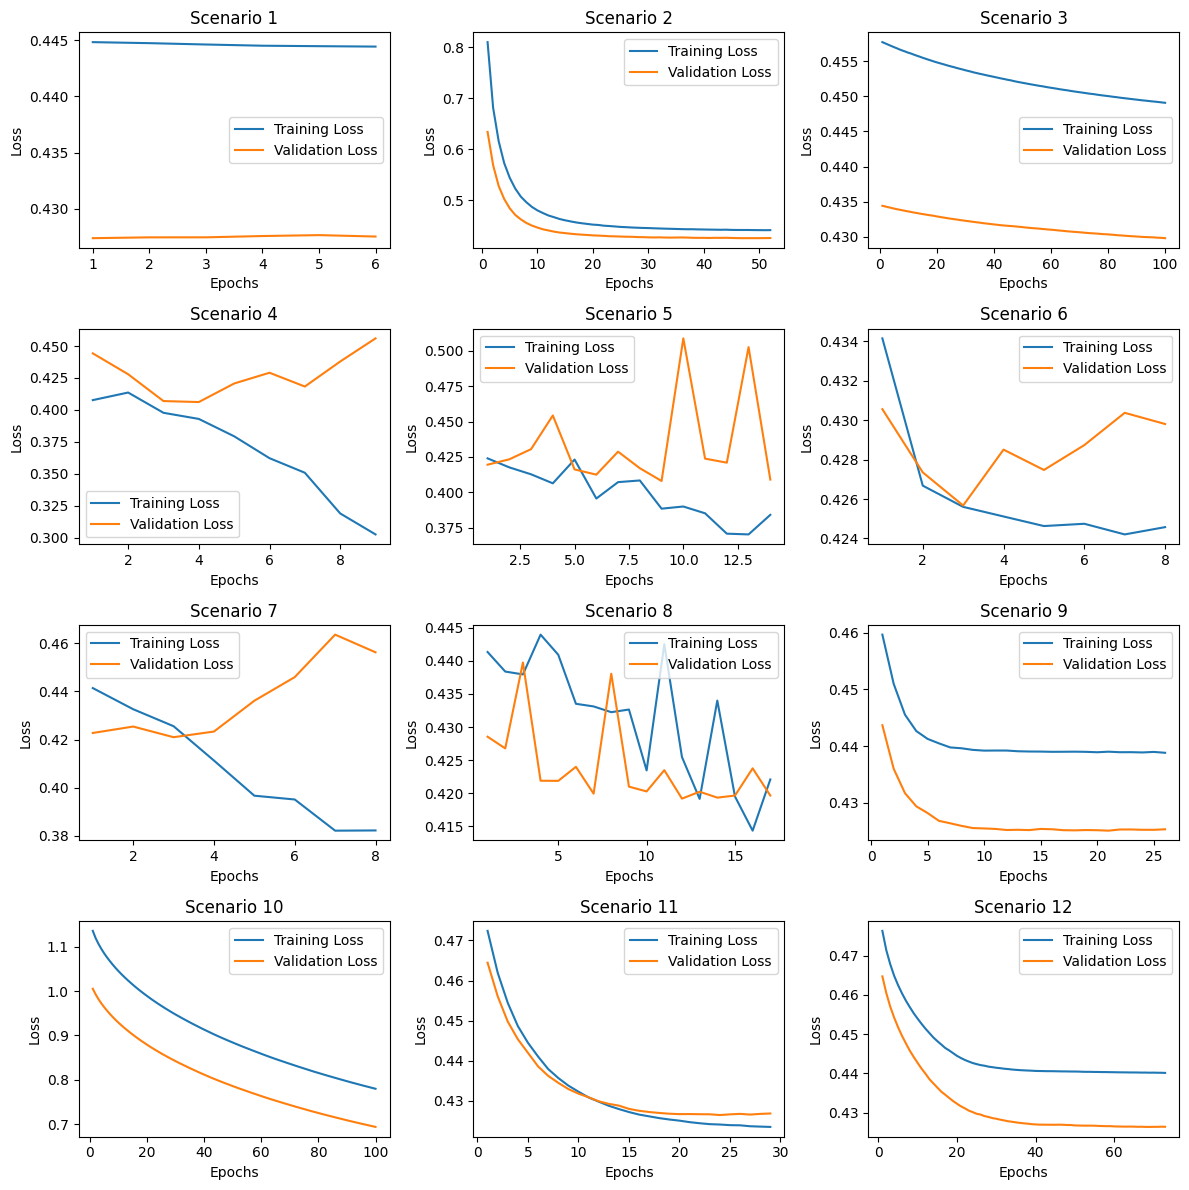

In [ ]:
# Plot train and validation loss graphs

train_losses = [train_loss_history1, train_loss_history2, train_loss_history3, train_loss_history4, train_loss_history5, train_loss_history6, train_loss_history7, train_loss_history8, train_loss_history9, train_loss_history10, train_loss_history11, train_loss_history12]
val_losses = [val_loss_history1, val_loss_history2, val_loss_history3, val_loss_history4, val_loss_history5, val_loss_history6, val_loss_history7, val_loss_history8, val_loss_history9, val_loss_history10, val_loss_history11, val_loss_history12]

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(12):
    epochs = range(1, len(train_losses[i]) + 1)
    axes[i].plot(epochs, train_losses[i], '-', label='Training Loss')
    axes[i].plot(epochs, val_losses[i], '-', label='Validation Loss')
    axes[i].set_title(f'Scenario {i+1}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

plt.tight_layout()
plt.show()


**EXPERIMENTS ON CNN**

In [ ]:
# Define the model 

def cnn_build_model(vocab_size, embedding_dim, max_seq_len, vectorise_layer, units, activation, optimiser, lr, loss):
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(vocab):
        if word in circumplex_model.wv.key_to_index:
            embedding_matrix[i] = circumplex_model.wv.get_vector(word)[:embedding_dim]

    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_len,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        mask_zero=True,
        trainable=True
    )

    inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)

    vectorised_inputs = vectorise_layer(inputs)

    embedded_inputs = embedding_layer(vectorised_inputs)

    conv1 = layers.Conv1D(filters=units, kernel_size=3, activation=activation, padding='valid')(embedded_inputs)
    conv2 = layers.Conv1D(filters=units, kernel_size=3, activation=activation, padding='valid')(conv1)
    pooling = layers.GlobalMaxPooling1D()(conv2)

    dense_layer = layers.Dense(units, activation=activation)(pooling)

    output_x = layers.Dense(1, activation=activation, name='x_output')(dense_layer)
    output_y = layers.Dense(1, activation=activation, name='y_output')(dense_layer)

    optimizer = tf.keras.optimizers.get(optimiser)
    optimizer.learning_rate = lr

    model = tf.keras.Model(inputs=inputs, outputs=[output_x, output_y], name="CNN_Regression")
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mse'])

    return model

cnn_model = cnn_build_model(vocab_size=2000, embedding_dim=150,
                    max_seq_len=600, vectorise_layer=vectorise_layer, units=32, 
                    activation='sigmoid', optimiser='adam', 
                    lr=0.001, loss="mse")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "CNN_Regression"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 600)       │          0 │ input_layer_43[0… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_43        │ (None, 600, 150)  │    300,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 598, 32)   │     14,432 │ embedding_43[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 596, 32)   │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │      1,056 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_output (Dense)    │ (None, 1)         │         33 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_output (Dense)    │ (None, 1)         │         33 │ dense_38[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 318,658 (1.22 MB)

 Trainable params: 318,658 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 - 2s - 340ms/step - loss: 0.7814 - x_output_mse: 0.5888 - y_output_mse: 0.1927 - val_loss: 0.6375 - val_x_output_mse: 0.4570 - val_y_output_mse: 0.1805
Epoch 2/100
5/5 - 0s - 77ms/step - loss: 0.6869 - x_output_mse: 0.5048 - y_output_mse: 0.1821 - val_loss: 0.5726 - val_x_output_mse: 0.3996 - val_y_output_mse: 0.1729
Epoch 3/100
5/5 - 0s - 77ms/step - loss: 0.6194 - x_output_mse: 0.4453 - y_output_mse: 0.1741 - val_loss: 0.5269 - val_x_output_mse: 0.3597 - val_y_output_mse: 0.1672
Epoch 4/100
5/5 - 0s - 77ms/step - loss: 0.5693 - x_output_mse: 0.4018 - y_output_mse: 0.1675 - val_loss: 0.4968 - val_x_output_mse: 0.3339 - val_y_output_mse: 0.1630
Epoch 5/100
5/5 - 0s - 77ms/step - loss: 0.5365 - x_output_mse: 0.3737 - y_output_mse: 0.1628 - val_loss: 0.4770 - val_x_output_mse: 0.3170 - val_y_output_mse: 0.1600
Epoch 6/100
5/5 - 0s - 74ms/step - loss: 0.5135 - x_output_mse: 0.3544 - y_output_mse: 0.1592 - val_loss: 0.4642 - val_x_output_mse: 0.3060 - val_y_output_mse: 0.15

In [ ]:
# Scenario 1: Activation: SIGMOID / Optimiser: ADAM
# Scenario 2: Activation: SIGMOID / Optimiser: RMSPROP
# Scenario 3: Activation: SIGMOID / Optimiser: SGD
# Scenario 4: Activation: SIGMOID / Optimiser: ADAGRAD
# Scenario 5: Activation: LINEAR / Optimiser: ADAM
# Scenario 6: Activation: LINEAR / Optimiser: RMSPROP
# Scenario 7: Activation: LINEAR / Optimiser: SGD
# Scenario 8: Activation: LINEAR / Optimiser: ADAGRAD
# Scenario 9: Activation: RELU / Optimiser: ADAM
# Scenario 10: Activation: RELU / Optimiser: RMSPROP
# Scenario 11: Activation: RELU / Optimiser: SGD
# Scenario 12: Activation: RELU / Optimiser: ADAGRAD

cnn_model1 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='adam', lr=0.001, loss="mse")
cnn_model2 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='rmsprop', lr=0.001, loss="mse")
cnn_model3 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='sgd', lr=0.001, loss="mse")
cnn_model4 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='sigmoid', optimiser='adagrad', lr=0.001, loss="mse")
cnn_model5 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='adam', lr=0.001, loss="mse")
cnn_model6 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='rmsprop', lr=0.001, loss="mse")
cnn_model7 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='sgd', lr=0.001, loss="mse")
cnn_model8 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='linear', optimiser='adagrad', lr=0.001, loss="mse")
cnn_model9 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='adam', lr=0.001, loss="mse")
cnn_model10 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='rmsprop', lr=0.001, loss="mse")
cnn_model11 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='sgd', lr=0.001, loss="mse")
cnn_model12 = cnn_build_model(vocab_size=2000, embedding_dim=embedding_dim, max_seq_len=max_seq_len, vectorise_layer=vectorise_layer, units=32, activation='relu', optimiser='adagrad', lr=0.001, loss="mse")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

In [ ]:
# Scenario 1

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results1 = cnn_model1.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss1 = cnn_results1.history['loss']
cnn_val_loss1 = cnn_results1.history['val_loss']
min_val_loss1_cnn = min(cnn_val_loss1)

cnn_predictions_xcoord1, cnn_predictions_ycoord1 = cnn_model1.predict(X_test)

cnn_mse_xcoord1 = mean_squared_error(y_test, cnn_predictions_xcoord1)
cnn_mse_ycoord1 = mean_squared_error(z_test, cnn_predictions_ycoord1)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4431 - x_output_mse: 0.2865 - y_output_mse: 0.1566 - val_loss: 0.4298 - val_x_output_mse: 0.2727 - val_y_output_mse: 0.1571
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4498 - x_output_mse: 0.2946 - y_output_mse: 0.1552 - val_loss: 0.4296 - val_x_output_mse: 0.2725 - val_y_output_mse: 0.1571
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4421 - x_output_mse: 0.2907 - y_output_mse: 0.1514 - val_loss: 0.4295 - val_x_output_mse: 0.2724 - val_y_output_mse: 0.1571
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4535 - x_output_mse: 0.2964 - y_output_mse: 0.1571 - val_loss: 0.4294 - val_x_output_mse: 0.2722 - val_y_output_mse: 0.1571
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4464 - x_output_mse: 0.2888 - y_output_mse: 0.1577 - val_loss: 0.4292 - val_x_output_mse: 0.2721 - val_y_output_mse: 0.1571
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.4432 - x_output_mse: 0.2964 - y_

In [ ]:
# Scenario 2

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results2 = cnn_model2.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss2 = cnn_results2.history['loss']
cnn_val_loss2 = cnn_results2.history['val_loss']
min_val_loss2_cnn = min(cnn_val_loss2)

cnn_predictions_xcoord2, cnn_predictions_ycoord2 = cnn_model2.predict(X_test)

cnn_mse_xcoord2 = mean_squared_error(y_test, cnn_predictions_xcoord2)
cnn_mse_ycoord2 = mean_squared_error(z_test, cnn_predictions_ycoord2)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 1.1060 - x_output_mse: 0.8813 - y_output_mse: 0.2247 - val_loss: 0.7962 - val_x_output_mse: 0.6057 - val_y_output_mse: 0.1906
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.8914 - x_output_mse: 0.7030 - y_output_mse: 0.1884 - val_loss: 0.6792 - val_x_output_mse: 0.4997 - val_y_output_mse: 0.1795
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.7304 - x_output_mse: 0.5536 - y_output_mse: 0.1768 - val_loss: 0.6061 - val_x_output_mse: 0.4342 - val_y_output_mse: 0.1719
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6660 - x_output_mse: 0.4915 - y_output_mse: 0.1745 - val_loss: 0.5608 - val_x_output_mse: 0.3933 - val_y_output_mse: 0.1674
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6168 - x_output_mse: 0.4460 - y_output_mse: 0.1707 - val_loss: 0.5286 - val_x_output_mse: 0.3648 - val_y_output_mse: 0.1638
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.5798 - x_output_mse: 0.4218 - y

In [ ]:
# Scenario 3

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results3 = cnn_model3.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss3 = cnn_results3.history['loss']
cnn_val_loss3 = cnn_results3.history['val_loss']
min_val_loss3_cnn = min(cnn_val_loss3)

cnn_predictions_xcoord3, cnn_predictions_ycoord3 = cnn_model3.predict(X_test)

cnn_mse_xcoord3 = mean_squared_error(y_test, cnn_predictions_xcoord3)
cnn_mse_ycoord3 = mean_squared_error(z_test, cnn_predictions_ycoord3)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.8225 - x_output_mse: 0.5172 - y_output_mse: 0.3054 - val_loss: 0.7389 - val_x_output_mse: 0.4497 - val_y_output_mse: 0.2892
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.8521 - x_output_mse: 0.5353 - y_output_mse: 0.3168 - val_loss: 0.7345 - val_x_output_mse: 0.4471 - val_y_output_mse: 0.2874
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.8288 - x_output_mse: 0.5200 - y_output_mse: 0.3088 - val_loss: 0.7301 - val_x_output_mse: 0.4444 - val_y_output_mse: 0.2857
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.8485 - x_output_mse: 0.5259 - y_output_mse: 0.3226 - val_loss: 0.7259 - val_x_output_mse: 0.4419 - val_y_output_mse: 0.2840
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.7990 - x_output_mse: 0.4999 - y_output_mse: 0.2991 - val_loss: 0.7217 - val_x_output_mse: 0.4395 - val_y_output_mse: 0.2823
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.7814 - x_output_mse: 0.5043 - y

In [ ]:
# Scenario 4

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results4 = cnn_model4.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss4 = cnn_results4.history['loss']
cnn_val_loss4 = cnn_results4.history['val_loss']
min_val_loss4_cnn = min(cnn_val_loss4)

cnn_predictions_xcoord4, cnn_predictions_ycoord4 = cnn_model4.predict(X_test)

cnn_mse_xcoord4 = mean_squared_error(y_test, cnn_predictions_xcoord4)
cnn_mse_ycoord4 = mean_squared_error(z_test, cnn_predictions_ycoord4)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.8316 - x_output_mse: 0.4239 - y_output_mse: 0.4077 - val_loss: 0.7491 - val_x_output_mse: 0.3664 - val_y_output_mse: 0.3826
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.8226 - x_output_mse: 0.4251 - y_output_mse: 0.3975 - val_loss: 0.7417 - val_x_output_mse: 0.3639 - val_y_output_mse: 0.3778
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.8037 - x_output_mse: 0.4050 - y_output_mse: 0.3987 - val_loss: 0.7351 - val_x_output_mse: 0.3616 - val_y_output_mse: 0.3736
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.7990 - x_output_mse: 0.4172 - y_output_mse: 0.3818 - val_loss: 0.7291 - val_x_output_mse: 0.3595 - val_y_output_mse: 0.3696
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.8018 - x_output_mse: 0.4080 - y_output_mse: 0.3938 - val_loss: 0.7237 - val_x_output_mse: 0.3577 - val_y_output_mse: 0.3661
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.7787 - x_output_mse: 0.4032 - y

In [ ]:
# Scenario 5

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results5 = cnn_model5.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss5 = cnn_results5.history['loss']
cnn_val_loss5 = cnn_results5.history['val_loss']
min_val_loss5_cnn = min(cnn_val_loss5)

cnn_predictions_xcoord5, cnn_predictions_ycoord5 = cnn_model5.predict(X_test)

cnn_mse_xcoord5 = mean_squared_error(y_test, cnn_predictions_xcoord5)
cnn_mse_ycoord5 = mean_squared_error(z_test, cnn_predictions_ycoord5)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 1.0629 - x_output_mse: 0.6921 - y_output_mse: 0.3708 - val_loss: 0.6004 - val_x_output_mse: 0.4257 - val_y_output_mse: 0.1747
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.5391 - x_output_mse: 0.3571 - y_output_mse: 0.1820 - val_loss: 0.5074 - val_x_output_mse: 0.2700 - val_y_output_mse: 0.2374
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.4363 - x_output_mse: 0.2621 - y_output_mse: 0.1742 - val_loss: 0.4595 - val_x_output_mse: 0.2651 - val_y_output_mse: 0.1944
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4394 - x_output_mse: 0.2710 - y_output_mse: 0.1684 - val_loss: 0.4163 - val_x_output_mse: 0.2650 - val_y_output_mse: 0.1513
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3443 - x_output_mse: 0.2338 - y_output_mse: 0.1104 - val_loss: 0.4251 - val_x_output_mse: 0.2681 - val_y_output_mse: 0.1570
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3497 - x_output_mse: 0.2438 - 

In [ ]:
# Scenario 6

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results6 = cnn_model6.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss6 = cnn_results6.history['loss']
cnn_val_loss6 = cnn_results6.history['val_loss']
min_val_loss6_cnn = min(cnn_val_loss6)

cnn_predictions_xcoord6, cnn_predictions_ycoord6 = cnn_model6.predict(X_test)

cnn_mse_xcoord6 = mean_squared_error(y_test, cnn_predictions_xcoord6)
cnn_mse_ycoord6 = mean_squared_error(z_test, cnn_predictions_ycoord6)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_12' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.7583 - x_output_mse: 0.3042 - y_output_mse: 0.4541 - val_loss: 0.4927 - val_x_output_mse: 0.3401 - val_y_output_mse: 0.1526
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.4203 - x_output_mse: 0.2734 - y_output_mse: 0.1469 - val_loss: 0.5050 - val_x_output_mse: 0.3340 - val_y_output_mse: 0.1710
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3938 - x_output_mse: 0.2494 - y_output_mse: 0.1444 - val_loss: 0.4093 - val_x_output_mse: 0.2617 - val_y_output_mse: 0.1476
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3901 - x_output_mse: 0.2643 - y_output_mse: 0.1258 - val_loss: 0.4006 - val_x_output_mse: 0.2585 - val_y_output_mse: 0.1421
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3301 - x_output_mse: 0.2157 - y_output_mse: 0.1144 - val_loss: 0.4464 - val_x_output_mse: 0.2713 - val_y_output_mse: 0.1751
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3383 - x_output_mse: 0.2210 - y

In [ ]:
# Scenario 7

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results7 = cnn_model7.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss7 = cnn_results7.history['loss']
cnn_val_loss7 = cnn_results7.history['val_loss']
min_val_loss7_cnn = min(cnn_val_loss7)

cnn_predictions_xcoord7, cnn_predictions_ycoord7 = cnn_model7.predict(X_test)

cnn_mse_xcoord7 = mean_squared_error(y_test, cnn_predictions_xcoord7)
cnn_mse_ycoord7 = mean_squared_error(z_test, cnn_predictions_ycoord7)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_14' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.8075 - x_output_mse: 0.6422 - y_output_mse: 0.1653 - val_loss: 0.6258 - val_x_output_mse: 0.4471 - val_y_output_mse: 0.1786
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6562 - x_output_mse: 0.4960 - y_output_mse: 0.1601 - val_loss: 0.5449 - val_x_output_mse: 0.3715 - val_y_output_mse: 0.1734
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5799 - x_output_mse: 0.4227 - y_output_mse: 0.1572 - val_loss: 0.4966 - val_x_output_mse: 0.3262 - val_y_output_mse: 0.1704
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5219 - x_output_mse: 0.3651 - y_output_mse: 0.1568 - val_loss: 0.4665 - val_x_output_mse: 0.2983 - val_y_output_mse: 0.1681
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4872 - x_output_mse: 0.3373 - y_output_mse: 0.1499 - val_loss: 0.4473 - val_x_output_mse: 0.2810 - val_y_output_mse: 0.1662
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4682 - x_output_mse: 0.3174 - y

In [ ]:
# Scenario 8

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results8 = cnn_model8.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss8 = cnn_results8.history['loss']
cnn_val_loss8 = cnn_results8.history['val_loss']
min_val_loss8_cnn = min(cnn_val_loss8)

cnn_predictions_xcoord8, cnn_predictions_ycoord8 = cnn_model8.predict(X_test)

cnn_mse_xcoord8 = mean_squared_error(y_test, cnn_predictions_xcoord8)
cnn_mse_ycoord8 = mean_squared_error(z_test, cnn_predictions_ycoord8)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_16' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.4517 - x_output_mse: 0.2847 - y_output_mse: 0.1670 - val_loss: 0.4529 - val_x_output_mse: 0.2738 - val_y_output_mse: 0.1791
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4408 - x_output_mse: 0.2744 - y_output_mse: 0.1664 - val_loss: 0.4499 - val_x_output_mse: 0.2739 - val_y_output_mse: 0.1760
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4326 - x_output_mse: 0.2666 - y_output_mse: 0.1660 - val_loss: 0.4548 - val_x_output_mse: 0.2775 - val_y_output_mse: 0.1773
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.4445 - x_output_mse: 0.2796 - y_output_mse: 0.1649 - val_loss: 0.4493 - val_x_output_mse: 0.2748 - val_y_output_mse: 0.1745
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.4371 - x_output_mse: 0.2759 - y_output_mse: 0.1611 - val_loss: 0.4489 - val_x_output_mse: 0.2751 - val_y_output_mse: 0.1738
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.4331 - x_output_mse: 0.2683 - 

In [ ]:
# Scenario 9

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results9 = cnn_model9.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss9 = cnn_results9.history['loss']
cnn_val_loss9 = cnn_results9.history['val_loss']
min_val_loss9_cnn = min(cnn_val_loss9)

cnn_predictions_xcoord9, cnn_predictions_ycoord9 = cnn_model9.predict(X_test)

cnn_mse_xcoord9 = mean_squared_error(y_test, cnn_predictions_xcoord9)
cnn_mse_ycoord9 = mean_squared_error(z_test, cnn_predictions_ycoord9)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_18' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.4656 - x_output_mse: 0.3071 - y_output_mse: 0.1585 - val_loss: 0.4177 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1495
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.4250 - x_output_mse: 0.2842 - y_output_mse: 0.1408 - val_loss: 0.4149 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1467
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4133 - x_output_mse: 0.2878 - y_output_mse: 0.1255 - val_loss: 0.4187 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1505
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4070 - x_output_mse: 0.2866 - y_output_mse: 0.1204 - val_loss: 0.4143 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1461
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3882 - x_output_mse: 0.2893 - y_output_mse: 0.0989 - val_loss: 0.4126 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1444
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3754 - x_output_mse: 0.2792 - y

In [ ]:
# Scenario 10

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results10 = cnn_model10.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss10 = cnn_results10.history['loss']
cnn_val_loss10 = cnn_results10.history['val_loss']
min_val_loss10_cnn = min(cnn_val_loss10)

cnn_predictions_xcoord10, cnn_predictions_ycoord10 = cnn_model10.predict(X_test)

cnn_mse_xcoord10 = mean_squared_error(y_test, cnn_predictions_xcoord10)
cnn_mse_ycoord10 = mean_squared_error(z_test, cnn_predictions_ycoord10)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_20' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.4953 - x_output_mse: 0.2999 - y_output_mse: 0.1954 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4776 - x_output_mse: 0.2849 - y_output_mse: 0.1927 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4778 - x_output_mse: 0.2828 - y_output_mse: 0.1950 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4895 - x_output_mse: 0.2872 - y_output_mse: 0.2023 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4834 - x_output_mse: 0.2866 - y_output_mse: 0.1968 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4934 - x_output_mse: 0.2942 - y

In [ ]:
# Scenario 11

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results11 = cnn_model11.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss11 = cnn_results11.history['loss']
cnn_val_loss11 = cnn_results11.history['val_loss']
min_val_loss11_cnn = min(cnn_val_loss11)

cnn_predictions_xcoord11, cnn_predictions_ycoord11 = cnn_model11.predict(X_test)

cnn_mse_xcoord11 = mean_squared_error(y_test, cnn_predictions_xcoord11)
cnn_mse_ycoord11 = mean_squared_error(z_test, cnn_predictions_ycoord11)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_22' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.4797 - x_output_mse: 0.2836 - y_output_mse: 0.1961 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4856 - x_output_mse: 0.2828 - y_output_mse: 0.2028 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4816 - x_output_mse: 0.2876 - y_output_mse: 0.1940 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4802 - x_output_mse: 0.2823 - y_output_mse: 0.1978 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4769 - x_output_mse: 0.2813 - y_output_mse: 0.1956 - val_loss: 0.4775 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.2093
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4876 - x_output_mse: 0.2883 - y

In [ ]:
# Scenario 12

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)

cnn_results12 = cnn_model12.fit(X_train, [y_train, z_train], validation_split = 0.25, epochs=100, batch_size=128, shuffle=True, callbacks = [stop], verbose = 1)
cnn_train_loss12 = cnn_results12.history['loss']
cnn_val_loss12 = cnn_results12.history['val_loss']
min_val_loss12_cnn = min(cnn_val_loss12)

cnn_predictions_xcoord12, cnn_predictions_ycoord12 = cnn_model12.predict(X_test)

cnn_mse_xcoord12 = mean_squared_error(y_test, cnn_predictions_xcoord12)
cnn_mse_ycoord12 = mean_squared_error(z_test, cnn_predictions_ycoord12)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d_24' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.4718 - x_output_mse: 0.2873 - y_output_mse: 0.1845 - val_loss: 0.4529 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1847
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.4713 - x_output_mse: 0.2901 - y_output_mse: 0.1812 - val_loss: 0.4447 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1765
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.4494 - x_output_mse: 0.2840 - y_output_mse: 0.1655 - val_loss: 0.4377 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1695
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.4470 - x_output_mse: 0.2822 - y_output_mse: 0.1648 - val_loss: 0.4338 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1656
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.4490 - x_output_mse: 0.2834 - y_output_mse: 0.1657 - val_loss: 0.4308 - val_x_output_mse: 0.2682 - val_y_output_mse: 0.1626
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.4504 - x_output_mse: 0.2914 - y

In [ ]:
# Print CNN experiment results

print(f'{"Scenario":15} {"Activation":15} {"Optimiser":15} {"Min. Loss":15} {"MSE x-coord":15} {"MSE y-coord"}')
print(f'{"1":15} {"sigmoid":15} {"adam":15} {round(min_val_loss1,4)} {round(cnn_mse_xcoord1,4):15} {round(cnn_mse_ycoord1,4):15}')
print(f'{"2":15} {"sigmoid":15} {"rmsprop":15} {round(min_val_loss2,4)} {round(cnn_mse_xcoord2,4):15} {round(cnn_mse_ycoord2,4):15}')
print(f'{"3":15} {"sigmoid":15} {"sgd":15} {round(min_val_loss3,4)} {round(cnn_mse_xcoord3,4):15} {round(cnn_mse_ycoord3,4):15}')
print(f'{"4":15} {"sigmoid":15} {"adagrad":15} {round(min_val_loss4,4)} {round(cnn_mse_xcoord4,4):15} {round(cnn_mse_ycoord4,4):15}')
print(f'{"5":15} {"linear":15} {"adam":15} {round(min_val_loss5,4)} {round(cnn_mse_xcoord5,4):15} {round(cnn_mse_ycoord5,4):15}')
print(f'{"6":15} {"linear":15} {"rmsprop":15} {round(min_val_loss6,4)} {round(cnn_mse_xcoord6,4):15} {round(cnn_mse_ycoord6,4):15}')
print(f'{"7":15} {"linear":15} {"sgd":15} {round(min_val_loss7,4)} {round(cnn_mse_xcoord7,4):15} {round(cnn_mse_ycoord7,4):15}')
print(f'{"8":15} {"linear":15} {"adagrad":15} {round(min_val_loss8,4)} {round(cnn_mse_xcoord8,4):15} {round(cnn_mse_ycoord8,4):15}')
print(f'{"9":15} {"relu":15} {"adam":15} {round(min_val_loss9,4)} {round(cnn_mse_xcoord9,4):15} {round(cnn_mse_ycoord9,4):15}')
print(f'{"10":15} {"relu":15} {"rmsprop":15} {round(min_val_loss10,4)} {round(cnn_mse_xcoord10,4):15} {round(cnn_mse_ycoord10,4):15}')
print(f'{"11":15} {"relu":15} {"sgd":15} {round(min_val_loss11,4)} {round(cnn_mse_xcoord11,4):15} {round(cnn_mse_ycoord11,4):15}')
print(f'{"12":15} {"relu":15} {"adagrad":15} {round(min_val_loss12,4)} {round(cnn_mse_xcoord12,4):15} {round(cnn_mse_ycoord12,4):15}')


Scenario        Activation      Optimiser       Min. Loss       MSE x-coord     MSE y-coord
1               sigmoid         adam            0.4274          0.3015          0.1436
2               sigmoid         rmsprop         0.4259          0.3001          0.1437
3               sigmoid         sgd             0.4298          0.3589          0.1726
4               sigmoid         adagrad         0.4061          0.3378          0.2146
5               linear          adam            0.408          0.2782          0.1332
6               linear          rmsprop         0.4257          0.2721          0.1368
7               linear          sgd             0.421          0.3063          0.1454
8               linear          adagrad         0.4192          0.3054          0.1541
9               relu            adam            0.4251          0.2998          0.1214
10              relu            rmsprop         0.6934          0.2998          0.1988
11              relu            sgd     

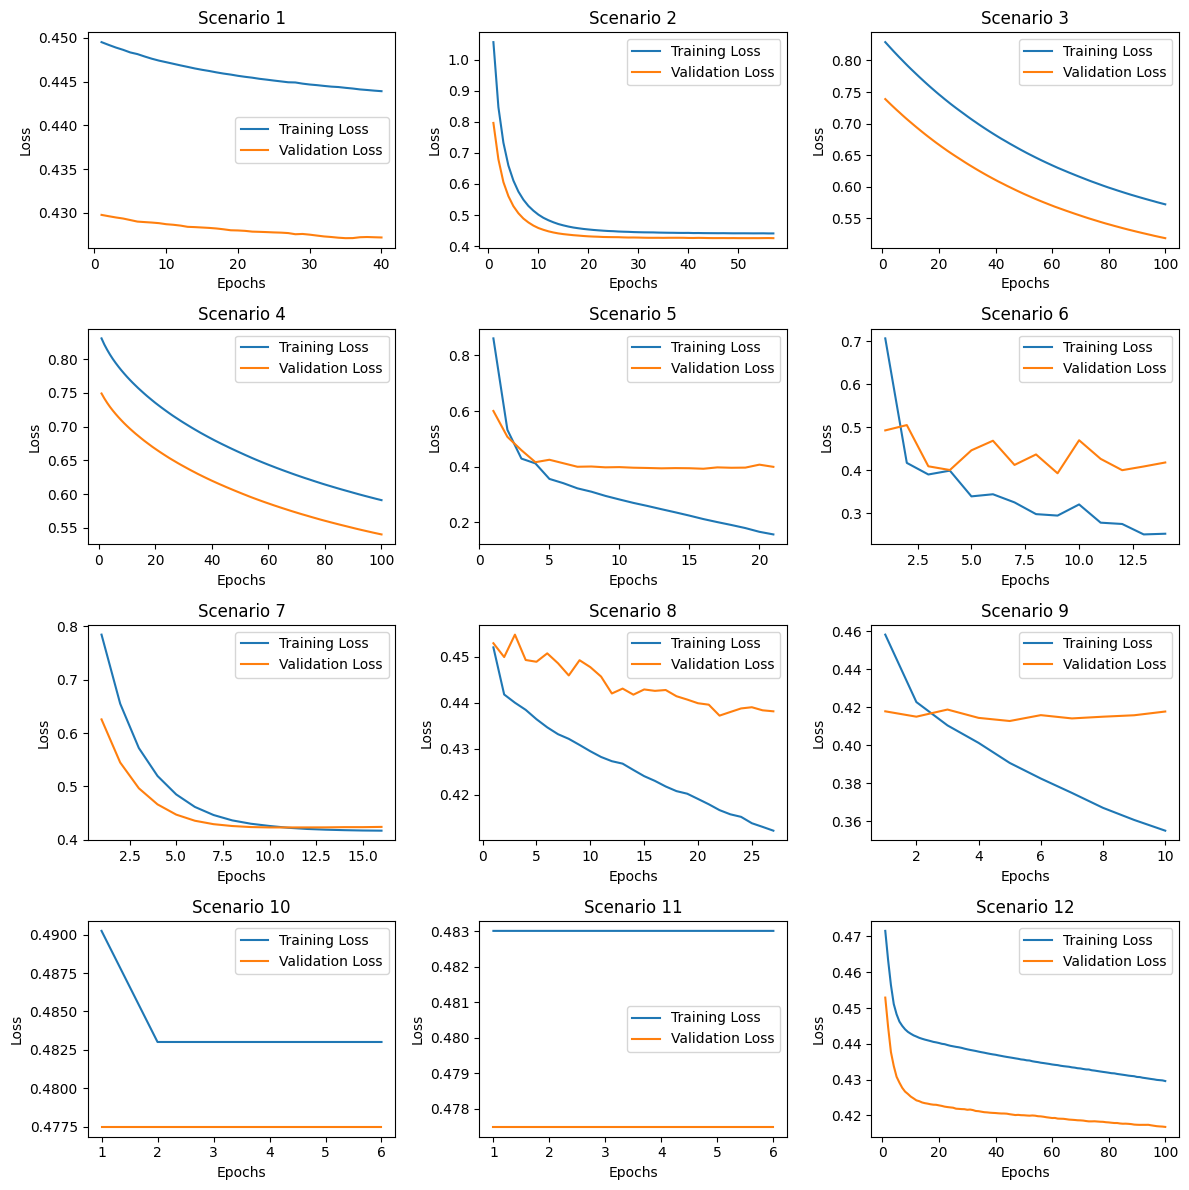

In [ ]:
# Plot train and validation loss graphs

cnn_train_losses = [cnn_train_loss1, cnn_train_loss2, cnn_train_loss3, cnn_train_loss4, cnn_train_loss5, cnn_train_loss6, cnn_train_loss7, cnn_train_loss8, cnn_train_loss9, cnn_train_loss10, cnn_train_loss11, cnn_train_loss12]
cnn_val_losses = [cnn_val_loss1, cnn_val_loss2, cnn_val_loss3, cnn_val_loss4, cnn_val_loss5, cnn_val_loss6, cnn_val_loss7, cnn_val_loss8, cnn_val_loss9, cnn_val_loss10, cnn_val_loss11, cnn_val_loss12]

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(12):
    epochs = range(1, len(cnn_train_losses[i]) + 1)
    axes[i].plot(epochs, cnn_train_losses[i], '-', label='Training Loss')
    axes[i].plot(epochs, cnn_val_losses[i], '-', label='Validation Loss')
    axes[i].set_title(f'Scenario {i+1}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

plt.tight_layout()
plt.show()


**HYPERPARAMETER TUNING FOR RANDOM FOREST REGRESSOR**

In [17]:
# Find best hyperparameters for random forest

import warnings
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore")

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(5, 51, 5),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=0, random_state=42, n_jobs=-1)

random_search.fit(X_train_vectors, y_train)

best_rf = random_search.best_estimator_

print("Best parameters:", random_search.best_params_)


Best parameters: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}


**CREATE DATAFRAME WITH LINEAR REGRESSOR AND RANDOM FOREST REGRESSOR PREDICTIONS**

In [18]:
# Train random forest regressor and make predictions

rf_pred = []
train_x_y = [y_train, z_train]

for i in range (2):
    rf_model_tuned = RandomForestRegressor(n_estimators= 700, min_samples_split= 5, min_samples_leaf= 1, max_features= 'log2', max_depth= 5, random_state=42)
    rf_model_tuned.fit(X_train_vectors, train_x_y[i])
    rf_predictions = rf_model_tuned.predict(X_test_vectors)
    rf_pred.append(rf_predictions)


In [19]:
# Create dataframe includes predictions of random forest and linear regression

lr_x_predictions = model_predictions_x[0]
lr_y_predictions = model_predictions_y[0]
rf_x = rf_pred[0]
rf_y = rf_pred[1]

song_ids = []
x_coord_list = data_csv['x'].tolist()
for y in y_test:
    index = x_coord_list.index(y)
    id = data_csv['question_id'][index]
    song_ids.append(id)

predictions_df = pd.DataFrame({'Song ID': song_ids,'Actual x coord': y_test.tolist(), 'LR x coord': lr_x_predictions.tolist() , 'RF x coord': rf_x, 'Actual y coord': z_test.tolist(), 'LR y coord': lr_y_predictions.tolist(), 'RF y coord': rf_y})

predictions_df

,Song ID,Actual x coord,LR x coord,RF x coord,Actual y coord,LR y coord,RF y coord
0,127,0.63,-0.052377,-0.136210,0.57,0.358480,0.315537
1,250,0.47,-0.062919,-0.211333,0.70,0.074352,0.194786
2,44,0.60,-0.104360,-0.088947,0.80,0.619044,0.418326
3,250,0.47,0.003553,-0.174878,0.03,0.071565,0.133480
4,4,-0.50,0.053754,-0.032893,-0.40,0.087826,0.102634
...,...,...,...,...,...,...,...
245,47,-0.70,-0.378079,-0.171754,0.30,0.067222,0.177013
246,83,0.27,-0.076931,-0.015540,0.67,0.615997,0.496832
247,4,-0.50,-0.166516,-0.177863,0.63,0.389748,0.178179
248,3,0.57,-0.187588,-0.180422,-0.07,0.151936,0.108884


**DEMONSTRATION**

Song ID    Song Name                 Artist               Type            Year            Actual Coordinates        LR Predicted              RF Predicted             
1          Drugz                     DopeSMOOTHIES        rap             2020            (-0.47, 0.37)             (0.13, 0.01)              (-0.02, 0.02)            
2          King me                   King_isaiahhh        rap             2015            (-0.47, -0.1)             (-0.34, 0.06)             (-0.21, 0.02)            
3          Ghetto Apostles           Shabazz the Disciple rap             1998            (-0.5, 0.47)              (-0.11, 0.05)             (-0.2, 0.19)             
4          Kasies Vibe               Kasie                rap             2020            (-0.73, -0.23)            (-0.22, 0.4)              (-0.24, 0.14)            
5          That Bird                 Young Mugz           rap             2016            (-0.57, 0.2)              (0.38, 0.24)              (-0.06, 0.08)     

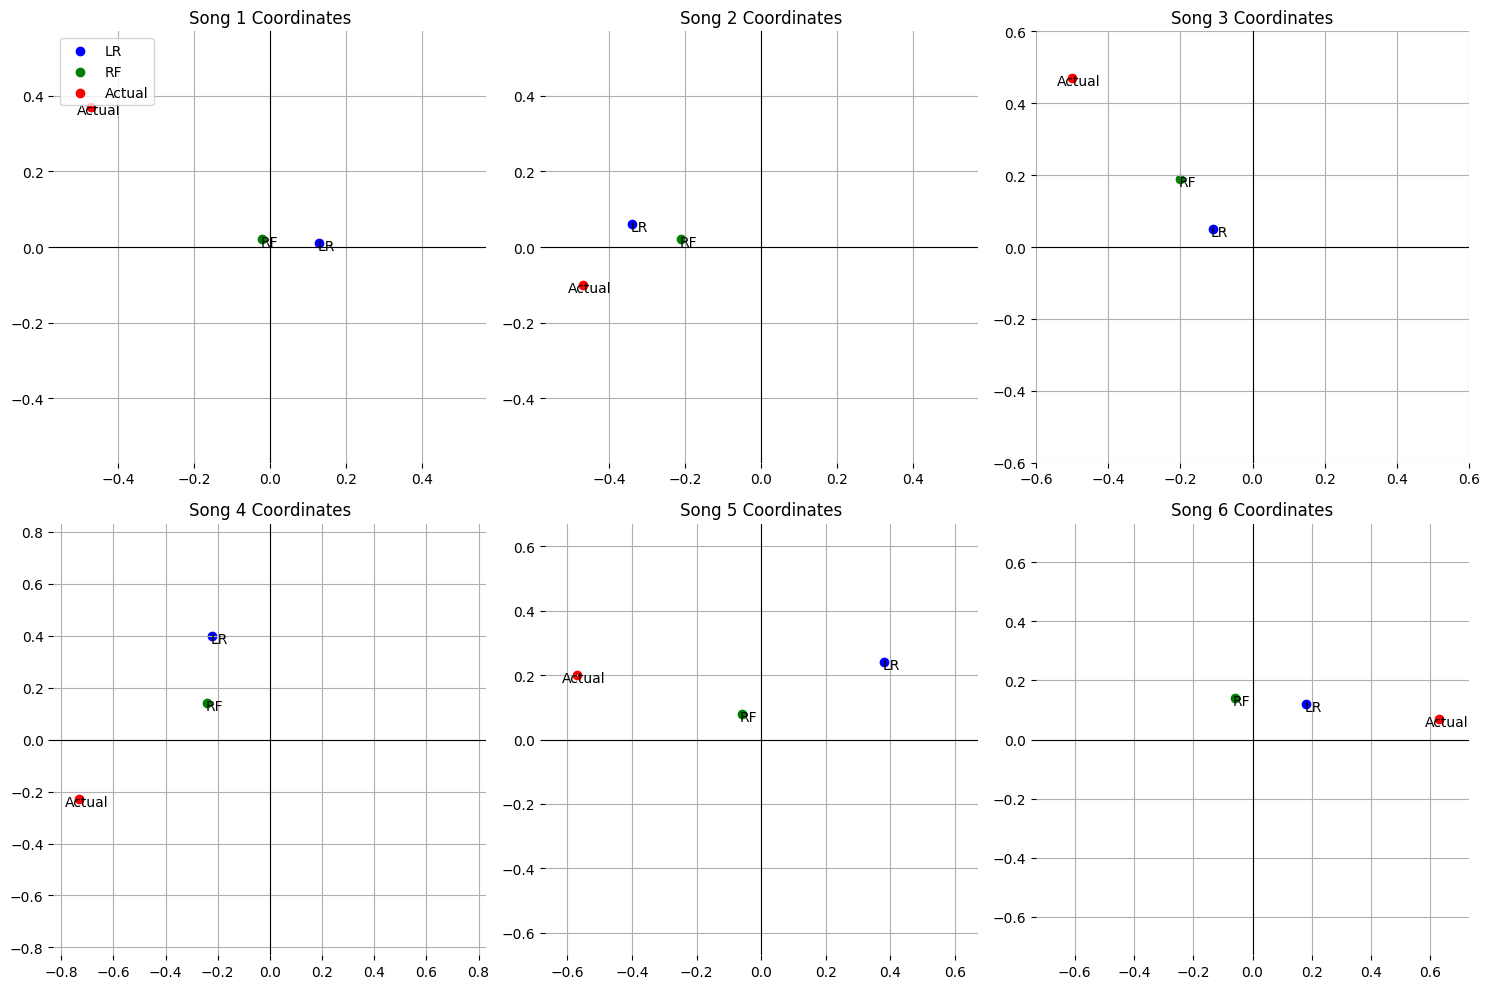

In [21]:
# Pick random predicted songs and actual values

songs = pd.read_csv('songs.csv')

song_ids = []

for i in range (6):
    index = np.random.choice(predictions_df.index)
    song_id = predictions_df['Song ID'][index]
    song_ids.append(song_id)

song_names = []
song_artists = []
song_tags = []
lr_coordinates = []
rf_coordinates = []
actual_coordinates = []
song_years = []

for j in song_ids:
    song_names.append(songs['title'][j])
    song_artists.append(songs['artist'][j])
    song_tags.append(songs['tag'][j])
    act_coord = (predictions_df['Actual x coord'][j], predictions_df['Actual y coord'][j])
    actual_coordinates.append(act_coord)
    lr_coord = (round(predictions_df['LR x coord'][j],2), round(predictions_df['LR y coord'][j],2))
    rf_coord = (round(predictions_df['RF x coord'][j],2), round(predictions_df['RF y coord'][j],2))
    lr_coordinates.append(lr_coord)
    rf_coordinates.append(rf_coord)
    song_years.append(songs['year'][j])

song_numbers = ['1', '2', '3', '4', '5', '6']

print(f'{"Song ID":10} {"Song Name":25} {"Artist":20} {"Type":15} {"Year":<15} {"Actual Coordinates":25} {"LR Predicted":25} {"RF Predicted":25}')

for k in range(len(song_names)):
    actual_coord_str = f"({actual_coordinates[k][0]}, {actual_coordinates[k][1]})"
    lr_coord_str = f"({lr_coordinates[k][0]}, {lr_coordinates[k][1]})"
    rf_coord_str = f"({rf_coordinates[k][0]}, {rf_coordinates[k][1]})"
    print(f'{song_numbers[k]:10} {song_names[k]:25} {song_artists[k]:20} {song_tags[k]:15} {str(song_years[k]):<15} {actual_coord_str:25} {lr_coord_str:25} {rf_coord_str:25}')

songs = ['Song 1', 'Song 2', 'Song 3', 'Song 4', 'Song 5', 'Song 6']

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

colors = {'LR': 'blue', 'RF': 'green', 'Actual': 'red'}

for i, ax in enumerate(axes):
    if i < len(songs):
        all_coords = lr_coordinates[i] + rf_coordinates[i] + actual_coordinates[i]
        all_x = [x for x, y in [lr_coordinates[i], rf_coordinates[i], actual_coordinates[i]]]
        all_y = [y for x, y in [lr_coordinates[i], rf_coordinates[i], actual_coordinates[i]]]

        max_range = max(abs(min(all_x + all_y)), abs(max(all_x + all_y))) + 0.1  # Ensuring the furthest point is within view and adding buffer

        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)

        # Plotting points and annotations
        ax.scatter(*lr_coordinates[i], color=colors['LR'], label='LR')
        ax.annotate('LR', lr_coordinates[i], textcoords="offset points", xytext=(5, -5), ha='center')

        ax.scatter(*rf_coordinates[i], color=colors['RF'], label='RF')
        ax.annotate('RF', rf_coordinates[i], textcoords="offset points", xytext=(5, -5), ha='center')

        ax.scatter(*actual_coordinates[i], color=colors['Actual'], label='Actual')
        ax.annotate('Actual', actual_coordinates[i], textcoords="offset points", xytext=(5, -5), ha='center')

        # Drawing zero lines for x and y axes
        ax.axhline(0, color='black', linewidth=0.8)
        ax.axvline(0, color='black', linewidth=0.8)

        # Hide the spines to emphasize free-floating plots
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.set_title(f'{songs[i]} Coordinates')
        ax.grid(True)

    else:
        ax.set_visible(False)  # Hide unused axes

axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()

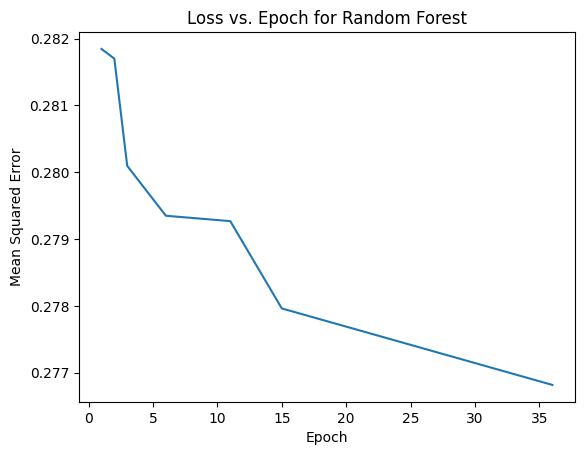

In [34]:
# Random Forest MSE vs. Epoch Graph

rf_model_tuned = RandomForestRegressor(n_estimators= 700, min_samples_split= 5, min_samples_leaf= 1, max_features= 'log2', max_depth= 10)

n_epochs = 200
rf_losses = [0.5]
best_epochs = []

for epoch in range(1, n_epochs + 1):
    
    rf_model_tuned.fit(X_train_vectors, y_train)
    
    x_coord_pred = rf_model_tuned.predict(X_test_vectors)
    mse = mean_squared_error(y_test, x_coord_pred)
    
    rf_losses.append(mse)
    best_epochs.append(epoch)
    
    loss_index = rf_losses.index(mse)
    if mse > rf_losses[loss_index - 1]:
        rf_losses.remove(mse)
        best_epochs.remove(epoch)
    
rf_losses.pop(0)

plt.plot(best_epochs, rf_losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Loss vs. Epoch for Random Forest')
plt.show()


In [35]:
# Load songs dataset and create a dataframe

song_csv = pd.read_csv('songs.csv')
song_df = pd.DataFrame(song_csv)
song_df

,song_id,artist,title,year,tag
0,1,Rich Amiri,Relax,2022,rap
1,2,Lil Calorie,Extra,2020,rap
2,3,Safaree,The Most Fun,2015,rap
3,4,Vanilla Taurus,California,2018,rap
4,5,ProduceKyro,Free Thinking,2021,rap
...,...,...,...,...,...
993,994,Kris Kristofferson & Brenda Lee,The Bigger the Fool the Harder the Fall,1982,country
994,995,The Osborne Brothers,Ruby Are You Mad,1959,country
995,996,Reba McEntire,A New Love,1989,country
996,997,Aaron Watson,Touchdown Town,2020,country


In [44]:
# Closest emotion function and trial

emotions = {
    'alarmed': (-0.2, 0.7),
    'afraid': (-0.4, 0.7),
    'angry': (-0.55, 0.65),
    'tense': (-0.4, 0.65),
    'frustrated': (-0.7, 0.55),
    'annoyed': (-0.6, 0.45),
    'distressed': (-0.7, 0.3),

    'astonished': (0.2, 1),
    'excited':(0.7, 0.85),
    'aroused': (0.25, 0.65),
    'happy': (0.9, 0.6), 
    'delighted': (0.65, 0.55),
    'glad': (0.75, 0.3),
    'pleased': (0.85, 0.2), 

    'content': (0.85, -0.15),
    'satisfied': (0.85, -0.2),
    'at ease': (0.65, -0.3),
    'serene':(0.6, -0.3),
    'calm': (0.6, -0.35),
    'relaxed': (0.8, -0.5),
    'sleepy': (0.3, -0.8),
    'tired': (0.5, -0.7),

    'miserable': (-0.75, -0.1),
    'sad': (-0.7, -0.3),
    'depressed': (-0.8, 0.3),
    'gloomy': (-0.8, -0.5),
    'bored': (-0.7, -0.7),
    'droopy': (-0.3, -0.7),
    
    }

def coord_to_emotion(x, y, emotions):
    converted_emotion = None
    min_distance = float('inf')

    for emotion, (x2, y2) in emotions.items():
        distance = math.sqrt((x - x2) ** 2 + (y - y2) ** 2)
        if distance < min_distance:
            min_distance = distance
            converted_emotion = emotion

    return converted_emotion


x_input = 0.8
y_input = -0.1
closest_emotion = coord_to_emotion(x_input, y_input, emotions)
print(f"The closest emotion to ({x_input}, {y_input}) is {closest_emotion}.")

The closest emotion to (0.8, -0.1) is content.


Predicting song...
The closest emotion to (-0.13, 0.07) is annoyed.
Song: Wonderfilled
  Actual Coordinates:    (x: -0.13, y: 0.07) - annoyed
  Predicted Coordinates: (x: -0.21, y: 0.18) - annoyed
----------------------------------------
Predicting song...
The closest emotion to (0.37, -0.03) is serene.
Song: Thank You for All Your Loving
  Actual Coordinates:    (x: 0.37, y: -0.03) - serene
  Predicted Coordinates: (x: -0.07, y: 0.17) - alarmed
----------------------------------------
Predicting song...
The closest emotion to (0.33, 0.63) is aroused.
Song: Animae
  Actual Coordinates:    (x: 0.33, y: 0.63) - aroused
  Predicted Coordinates: (x: 0.03, y: 0.48) - aroused
----------------------------------------
Predicting song...
The closest emotion to (-0.6, 0.4) is annoyed.
Song: My Only One
  Actual Coordinates:    (x: -0.6, y: 0.4) - annoyed
  Predicted Coordinates: (x: -0.16, y: 0.37) - alarmed
----------------------------------------
Predicting song...
The closest emotion to (-0.7

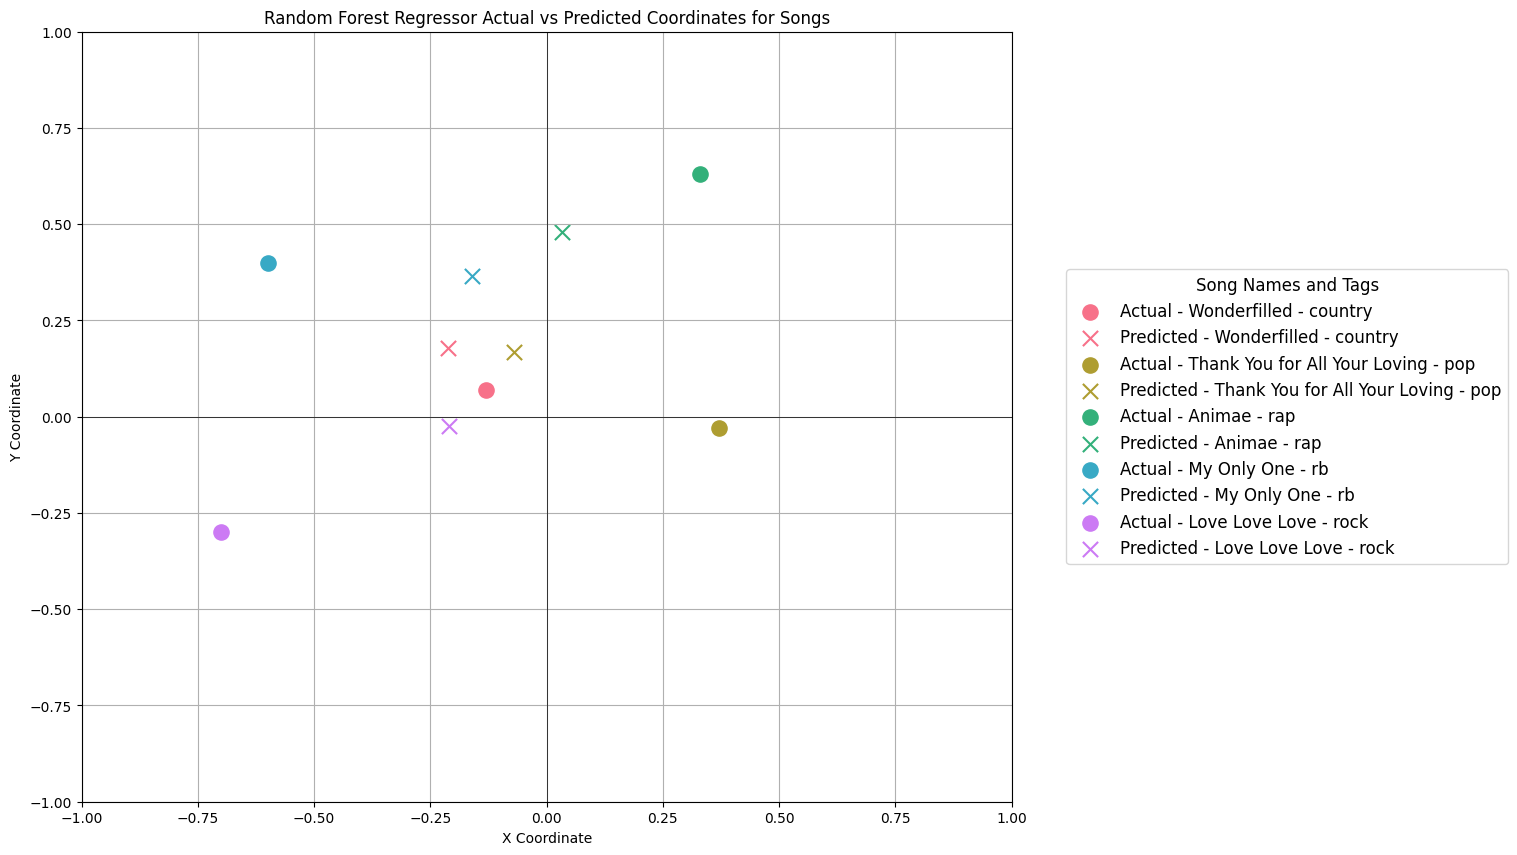

In [90]:
# Plot the coordinate system that shows predicted and actual coordinates of songs. COPY

song_csv = pd.read_csv('songs.csv')
song_df = pd.DataFrame(song_df)

random_songs = df.groupby('tag').apply(lambda x: x.sample(1, random_state=12)).reset_index(drop=True)

actual_coords = []
pred_coords = []
titles = []
tags = []

unique_tags = random_songs['tag'].unique()
tag_colors = sns.color_palette("husl", len(unique_tags))  
tag_color_map = dict(zip(unique_tags, tag_colors)) 

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

rf_model_x = RandomForestRegressor(n_estimators= 700, min_samples_split= 5, min_samples_leaf= 1, max_features= 'log2', max_depth= 5, random_state=42)
rf_model_y = RandomForestRegressor(n_estimators= 700, min_samples_split= 5, min_samples_leaf= 1, max_features= 'log2', max_depth= 5, random_state=42)

rf_model_x.fit(X_train_vectors, y_train)
rf_model_y.fit(X_train_vectors, z_train)

for _, row in random_songs.iterrows():
    actual_x = row['x']
    actual_y = row['y']
    
    processed_lyrics = np.array([row['processed_lyrics']])
    print("\033[35;1mPredicting song...\033[0m")

    processed_lyrics_vector = np.array(row['lyrics_vector']).reshape(1, -1)

    predicted_x = rf_model_x.predict(processed_lyrics_vector)[0]
    predicted_y = rf_model_y.predict(processed_lyrics_vector)[0]
    
    actual_coords.append((actual_x, actual_y))
    pred_coords.append((predicted_x, predicted_y))
    titles.append(f"{song_df.iloc[(row['question_id'] - 1)]['title']}")
    tags.append(row['tag'])

    closest_emotion_actual = coord_to_emotion(actual_x, actual_y, emotions)
    closest_emotion_pred = coord_to_emotion(predicted_x, predicted_y, emotions)
    print(f"The closest emotion to ({actual_x}, {actual_y}) is {closest_emotion_actual}.")
    print(f"Song: \033[36;1m{titles[-1]}\033[0m")
    print(f"  Actual Coordinates:    (x: \033[34m{actual_x}\033[0m, y: \033[34m{actual_y}\033[0m) - \033[34m{closest_emotion_actual}\033[0m")
    print(f"  Predicted Coordinates: (x: \033[32m{predicted_x:.2f}\033[0m, y: \033[32m{predicted_y:.2f}\033[0m) - \033[34m{closest_emotion_pred}\033[0m")
    print("-" * 40)

actual_coords = np.array(actual_coords)
pred_coords = np.array(pred_coords)

plt.figure(figsize=(12, 10))

for i, (actual_coord, pred_coord, title, tag) in enumerate(zip(actual_coords, pred_coords, titles, tags)):
    plt.scatter(
        actual_coord[0], actual_coord[1],
        color=tag_color_map[tag], 
        label=f'Actual - {title} - {tag}', 
        marker='o',
        s=120
    )
    
    plt.scatter(
        pred_coord[0], pred_coord[1],
        color=tag_color_map[tag], 
        label=f'Predicted - {title} - {tag}', 
        marker='x',
        s=120
    )

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.05, 0.5), title='Song Names and Tags', fontsize = 'large', title_fontsize = 'large', markerscale = 1)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Random Forest Regressor Actual vs Predicted Coordinates for Songs')
plt.grid(True)

plt.savefig('RandomForest_PredictedvsActual.png', format='png', dpi=300, bbox_inches='tight')

plt.show()
